In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")  
from openai import OpenAI
import re
from typing import Optional
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
import csv

In [ ]:
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'
TIME = 'time'
VALUE = 'value'
NAME = 'name'

DATASET ='B'
DATA_DIR = 'LLM_segment_B'

# api_key = DEEPSEEK_API_KEY  
# client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
# model_name = "deepseek-chat"
# MODEL="deepseek"

api_key = OPENAI_API_KEY
client = OpenAI(api_key=api_key)
model_name="gpt-4o-mini-2024-07-18"
MODEL="gpt-4o-mini"
temperature=0

In [7]:
import sys
sys.path.append("..")  
from data_load.load_data import load_ordoneza_dataset_nochange
from pathlib import Path

dataset_b = load_ordoneza_dataset_nochange(Path("../dataset/UCI_ADL_Binary"), part=DATASET)
print(dataset_b['activities'].head())
print(dataset_b['devices'].head())
print(dataset_b.keys())
print(dataset_b['activity_list'])

Corrections applied to OrdonezB activities:
Adjusted Toileting end from 2012-11-14 00:29:59 to 2012-11-14 00:29:00 due to overlap with Sleeping
Adjusted Spare_Time/TV end from 2012-11-14 12:52:59 to 2012-11-14 12:52:00 due to overlap with Leaving
Adjusted Spare_Time/TV end from 2012-11-14 21:37:59 to 2012-11-14 21:37:00 due to overlap with Dinner
Adjusted Spare_Time/TV end from 2012-11-14 22:14:59 to 2012-11-14 22:14:00 due to overlap with Snack
Adjusted Sleeping start from 2012-11-15 00:10:00 to 2012-11-15 00:10:59 due to overlap with Grooming
Adjusted Sleeping end from 2012-11-15 00:43:59 to 2012-11-15 00:43:00 due to overlap with Spare_Time/TV
Adjusted Spare_Time/TV end from 2012-11-17 20:26:59 to 2012-11-17 20:26:00 due to overlap with Snack
Adjusted Spare_Time/TV end from 2012-11-19 21:59:59 to 2012-11-19 21:59:00 due to overlap with Dinner
Adjusted Snack end from 2012-11-19 22:32:59 to 2012-11-19 22:32:00 due to overlap with Spare_Time/TV
Adjusted Leaving end from 2012-11-22 01:4

In [8]:
import pandas as pd
from io import StringIO

def convert_events_to_states(event_df):
    """
    将二值传感器事件流转换为传感器状态流，适配特定传感器列表，并包含位置信息。
    
    参数:
    event_df: DataFrame 包含 Start time, End time, Location, Type, Place 列
    
    返回:
    DataFrame 包含状态的开始时间、结束时间和状态描述
    """
    # 创建空的列表来存储状态
    states = []
    
    # 确保时间列是 datetime 类型
    event_df['start_time'] = pd.to_datetime(event_df['start_time'])
    event_df['end_time'] = pd.to_datetime(event_df['end_time'])

    # 清除 location 和 place 列的空格并删除 NaN 行
    event_df['location'] = event_df['location'].str.strip()
    event_df['place'] = event_df['place'].str.strip()
    event_df.dropna(subset=['location', 'place'], inplace=True)
    
    # 定义传感器类型到状态的映射
    state_mappings = {
        'PIR': {
            'Door': {'Living': 'NearLivingArea', 'Kitchen': 'NearKitchenArea', 'Bedroom': 'NearBedroomArea', 'Bathroom': 'NearBathroomArea'},
            'Basin': {'Bathroom': 'NearBathroomBasin'},
            'Shower': {'Bathroom': 'NearBathroomShower'},
        },
        'Magnetic': {
            'Fridge': {'Kitchen': 'FridgeDoorOpen'},
            'Cupboard': {'Kitchen': 'CupboardDoorOpen'},
            'Maindoor': {'Entrance': 'MainDoorOpen'},
        },
        'Flush': {
            'Toilet': {'Toilet': 'ToiletFlushing'}
        },
        'Pressure': {
            'Seat': {'Living': 'SeatOccupied'},
            'Bed': {'Bedroom': 'BedOccupied'}
        },
        'Electric': {
            'Microwave': {'Kitchen': 'MicrowaveOn'}
        }
    }
    
    # 对每一行进行处理
    for index, row in event_df.iterrows():
        # 获取传感器类型和位置
        sensor_type = row['type']
        location = row['location']
        place = row['place']
        
        # 根据传感器类型和位置生成状态名称
        if sensor_type in state_mappings and location in state_mappings[sensor_type] and place in state_mappings[sensor_type][location]:
            state_name = state_mappings[sensor_type][location][place]
        else:
            # 默认情况：使用 Location + Type
            state_name = f"{location}{sensor_type}"
        
        # 创建状态描述，格式为 st(state_name, start_time, end_time)
        state_desc = f"st({place}-{state_name}, {row['start_time'].strftime('%H:%M')}, {row['end_time'].strftime('%H:%M')})"
        
        # 添加到状态列表
        states.append({
            'state': state_desc,
            'start_time': row['start_time'],
            'end_time': row['end_time'],
            'location': row['location'],
            'type': row['type'],
            'place': row['place'],
            'device': row['device']
        })
    
    # 创建结果 DataFrame
    result_df = pd.DataFrame(states)
    
    # 按时间排序
    result_df = result_df.sort_values('start_time')
    
    return result_df


# 转换事件到状态
state_df = convert_events_to_states(dataset_b['devices'])

# 打印结果
print(state_df)
# state_df.head(40)

                                          state          start_time  \
0         st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:14:21   
1       st(Living-NearLivingArea, 00:22, 00:22) 2012-11-12 00:22:57   
2     st(Kitchen-NearKitchenArea, 00:23, 00:23) 2012-11-12 00:23:14   
3     st(Kitchen-NearKitchenArea, 00:24, 00:24) 2012-11-12 00:24:20   
4       st(Living-NearLivingArea, 00:24, 00:24) 2012-11-12 00:24:42   
...                                         ...                 ...   
2329  st(Bedroom-NearBedroomArea, 20:41, 20:41) 2012-12-02 20:41:25   
2330    st(Living-NearLivingArea, 20:41, 20:41) 2012-12-02 20:41:44   
2331    st(Living-NearLivingArea, 21:18, 21:18) 2012-12-02 21:18:10   
2332    st(Living-NearLivingArea, 21:18, 21:18) 2012-12-02 21:18:28   
2333      st(Living-SeatOccupied, 21:19, 01:03) 2012-12-02 21:19:12   

                end_time location      type    place                device  
0    2012-11-12 00:21:49     Seat  Pressure   Living  Living_Seat_Pres

In [10]:
import pandas as pd

def identify_activity_edges_from_raw_data(df):
    """
    根据传感器原始数据识别活动边缘（开始时间和结束时间）。
    假设输入数据的列包含 'start_time', 'end_time', 'state', 'location', 'place' 等。
    """
    # 确保时间列是 datetime 类型
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])

    # 系统提示，指导模型直接从传感器数据推断活动
    system_prompt = """
    Analyze the provided raw sensor data and identify distinct indoor human activities.
    For each activity, determine the start and end times based on the sensor events.
    Ensure each activity segment has a complete semantic meaning and accurately reflects the corresponding time range.  

    Please note that activities include, but are not limited to:
    sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,preparing dinner,snacking
        
    Return only the result in the following table format without header, without any additional explanations or summaries:
    Start time(YYYY-MM-DD HH:MM:SS),End time(YYYY-MM-DD HH:MM:SS),Activity
    
    """
    
    # 将 DataFrame 转换为字符串形式的描述，以便传递给模型
    data_str = df.to_string(index=False)

    try:
        response = client.chat.completions.create(
            model=model_name,  # 确保 model_name 已定义
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Raw sensor data:\n{data_str}"}
            ],
            max_tokens=1000,
            temperature=0.0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error identifying activity edges: {str(e)}"

def run_pipeline(df, window_size=50, activity_output_path="predict_self_gpt_B/new.txt"):
    """
    运行整个流程：直接从传感器原始数据识别活动边缘，并将活动信息保存到文件中。
    将 DataFrame 分割成指定大小的窗口，并以指定表格形式输出活动信息。
    """
    num_rows = len(df)
    
    with open(activity_output_path, "w", encoding="utf-8") as activity_file:
        for i in range(0, num_rows, window_size):
            window = df.iloc[i:i + window_size]
            
            if not window.empty:
                activity_edges = identify_activity_edges_from_raw_data(window)
                
                activity_file.write(f"{activity_edges}\n\n")
                print(f"Window {i // window_size + 1}:\n{activity_edges}\n")
    
    print(f"Activity edges saved to: {activity_output_path}")


run_pipeline(dataset_b['devices'], window_size=15)  # 设置窗口大小为 10

C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 1:
2012-11-11 21:14:21,2012-11-12 00:21:49,relaxing on couch  
2012-11-12 00:22:57,2012-11-12 00:22:59,leaving home  
2012-11-12 00:23:14,2012-11-12 00:23:17,leaving home  
2012-11-12 00:24:20,2012-11-12 00:24:22,leaving home  
2012-11-12 00:24:42,2012-11-12 00:24:54,leaving home  
2012-11-12 00:25:35,2012-11-12 00:42:56,relaxing on couch  
2012-11-12 00:43:46,2012-11-12 00:43:49,leaving home  
2012-11-12 00:46:12,2012-11-12 00:46:15,leaving home  
2012-11-12 00:47:21,2012-11-12 00:47:24,leaving home  
2012-11-12 00:48:38,2012-11-12 00:50:12,personal care  
2012-11-12 00:50:29,2012-11-12 00:50:32,leaving home  
2012-11-12 00:51:18,2012-11-12 01:52:12,relaxing on couch  
2012-11-12 01:53:19,2012-11-12 01:53:22,leaving home  
2012-11-12 01:53:27,2012-11-12 01:53:35,personal care  
2012-11-12 01:53:39,2012-11-12 01:54:27,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 2:
2012-11-12 01:55:09,2012-11-12 09:30:35,Sleeping  
2012-11-12 09:37:28,2012-11-12 09:38:45,Personal Care  
2012-11-12 09:40:17,2012-11-12 09:40:22,Leaving Home  
2012-11-12 09:42:02,2012-11-12 09:50:02,Preparing Breakfast  
2012-11-12 09:57:36,2012-11-12 10:14:50,Relaxing on Couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 3:
2012-11-12 10:18:19,2012-11-12 10:20:15,Bathing  
2012-11-12 10:21:39,2012-11-12 10:29:45,Showering  
2012-11-12 10:34:11,2012-11-12 10:35:02,Personal Care  
2012-11-12 10:35:14,2012-11-12 10:40:01,Personal Care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 4:
2012-11-12 10:42:05,2012-11-12 10:42:07,Bathing
2012-11-12 10:47:17,2012-11-12 10:47:24,Leaving home
2012-11-12 11:04:53,2012-11-12 11:04:56,Returning home
2012-11-12 11:05:44,2012-11-12 11:06:34,Preparing breakfast
2012-11-12 11:09:44,2012-11-12 11:10:42,Using microwave
2012-11-12 11:20:40,2012-11-12 11:20:45,Returning to kitchen
2012-11-12 11:21:26,2012-11-12 11:21:30,Returning to living room
2012-11-12 11:23:34,2012-11-12 11:23:37,Returning to living room
2012-11-12 11:24:12,2012-11-12 11:24:17,Entering bedroom
2012-11-12 11:32:27,2012-11-12 11:32:29,Entering bedroom
2012-11-12 11:32:39,2012-11-12 11:32:41,Returning to kitchen
2012-11-12 11:33:15,2012-11-12 11:33:17,Returning to kitchen
2012-11-12 11:34:08,2012-11-12 11:34:10,Entering bedroom
2012-11-12 11:34:45,2012-11-12 11:34:52,Staying in bedroom



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 5:
2012-11-12 11:37:49,2012-11-12 11:40:06,preparing breakfast  
2012-11-12 11:40:06,2012-11-12 11:47:09,relaxing on couch  
2012-11-12 11:47:09,2012-11-12 11:47:48,leaving home  
2012-11-12 11:47:48,2012-11-12 12:01:50,relaxing on couch  
2012-11-12 12:01:50,2012-11-12 12:02:09,leaving home  
2012-11-12 12:02:09,2012-11-12 12:22:30,personal care  
2012-11-12 12:22:30,2012-11-12 12:23:48,relaxing on couch  
2012-11-12 12:23:48,2012-11-12 12:37:03,preparing lunch  
2012-11-12 12:37:03,2012-11-12 12:39:42,relaxing on couch  
2012-11-12 12:39:42,2012-11-12 12:42:39,personal care  
2012-11-12 12:42:39,2012-11-12 12:49:23,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 6:
2012-11-12 12:52:58,2012-11-12 12:55:12,Bathroom personal care  
2012-11-12 13:00:02,2012-11-12 13:07:11,Bathroom personal care  
2012-11-12 13:12:47,2012-11-12 13:18:24,Bathroom personal care  
2012-11-12 13:52:31,2012-11-12 13:55:39,Preparing lunch  
2012-11-12 14:00:02,2012-11-12 14:00:05,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 7:
2012-11-12 14:39:01,2012-11-12 14:39:21,preparing breakfast  
2012-11-12 14:48:44,2012-11-12 14:49:33,leaving home  
2012-11-12 14:51:33,2012-11-12 14:53:14,preparing lunch  
2012-11-12 15:22:47,2012-11-12 15:23:02,relaxing on couch  
2012-11-12 15:23:38,2012-11-12 15:31:53,preparing dinner  
2012-11-12 15:38:50,2012-11-12 15:40:39,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 8:
2012-11-12 15:42:55,2012-11-12 15:42:58,leaving home  
2012-11-12 15:43:15,2012-11-12 16:10:35,relaxing on couch  
2012-11-12 16:11:28,2012-11-12 16:11:34,leaving home  
2012-11-12 16:22:22,2012-11-12 16:22:29,leaving home  
2012-11-12 17:08:34,2012-11-12 17:08:37,leaving home  
2012-11-12 17:10:11,2012-11-12 17:10:14,leaving home  
2012-11-12 17:29:17,2012-11-12 17:29:21,leaving home  
2012-11-12 17:29:30,2012-11-12 17:29:33,leaving home  
2012-11-12 17:29:50,2012-11-12 17:29:52,leaving home  
2012-11-12 17:30:08,2012-11-12 17:30:16,leaving home  
2012-11-12 17:35:38,2012-11-12 17:35:42,leaving home  
2012-11-12 17:43:33,2012-11-12 17:44:31,personal care  
2012-11-12 17:43:55,2012-11-12 17:44:07,personal care  
2012-11-12 17:44:37,2012-11-12 17:44:40,leaving home  
2012-11-12 17:45:22,2012-11-12 18:46:58,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 9:
2012-11-12 18:47:29,2012-11-12 18:47:32,leaving home  
2012-11-12 18:47:45,2012-11-12 18:47:49,leaving home  
2012-11-12 18:52:17,2012-11-12 18:52:33,preparing dinner  
2012-11-12 18:52:42,2012-11-12 18:53:43,preparing dinner  
2012-11-12 18:56:12,2012-11-12 18:56:15,leaving home  
2012-11-12 19:00:51,2012-11-12 19:00:56,leaving home  
2012-11-12 19:02:07,2012-11-12 19:02:10,leaving home  
2012-11-12 19:02:15,2012-11-12 19:02:19,leaving home  
2012-11-12 19:03:07,2012-11-12 20:56:46,relaxing on couch  
2012-11-12 20:57:05,2012-11-12 20:57:07,leaving home  
2012-11-12 20:57:11,2012-11-12 20:57:23,leaving home  
2012-11-12 20:59:39,2012-11-12 20:59:42,leaving home  
2012-11-12 21:06:32,2012-11-12 21:06:35,leaving home  
2012-11-12 21:11:39,2012-11-12 21:11:58,leaving home  
2012-11-12 21:14:56,2012-11-12 21:15:03,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 10:
2012-11-12 21:15:13,2012-11-12 21:15:17,leaving home  
2012-11-12 22:34:24,2012-11-12 22:34:30,preparing dinner  
2012-11-12 22:36:23,2012-11-12 22:36:58,preparing dinner  
2012-11-12 22:53:46,2012-11-12 22:54:14,personal care  
2012-11-12 22:55:02,2012-11-12 23:34:30,relaxing on couch  
2012-11-12 23:34:40,2012-11-12 23:37:59,personal care  
2012-11-12 23:36:51,2012-11-12 23:36:51,snacking



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 11:
2012-11-12 23:47:02,2012-11-13 01:26:16,relaxing on couch  
2012-11-13 01:29:06,2012-11-13 01:29:39,personal care  
2012-11-13 01:30:32,2012-11-13 08:51:15,sleeping  
2012-11-13 08:52:03,2012-11-13 08:52:06,leaving home  
2012-11-13 08:53:48,2012-11-13 08:56:57,preparing breakfast  
2012-11-13 08:57:49,2012-11-13 09:00:26,snacking



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 12:
2012-11-13 09:11:46,2012-11-13 09:15:53,Bathing  
2012-11-13 09:21:24,2012-11-13 09:24:26,Personal Care  
2012-11-13 09:29:37,2012-11-13 09:30:26,Personal Care  
2012-11-13 09:34:55,2012-11-13 09:36:50,Personal Care  
2012-11-13 09:05:26,2012-11-13 09:10:12,Leaving Home  
2012-11-13 09:53:15,2012-11-13 10:12:02,Preparing Breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 13:
2012-11-13 10:12:10,2012-11-13 10:12:12,leaving home  
2012-11-13 10:14:04,2012-11-13 10:14:07,leaving home  
2012-11-13 10:49:34,2012-11-13 10:49:38,leaving home  
2012-11-13 10:50:05,2012-11-13 10:50:08,leaving home  
2012-11-13 10:51:52,2012-11-13 10:51:55,leaving home  
2012-11-13 10:52:45,2012-11-13 13:41:54,snacking  
2012-11-13 13:42:06,2012-11-13 13:42:10,preparing lunch  
2012-11-13 13:42:45,2012-11-13 13:42:48,preparing lunch  
2012-11-13 13:43:20,2012-11-13 13:43:21,leaving home  
2012-11-13 13:45:56,2012-11-13 13:45:58,leaving home  
2012-11-13 13:47:45,2012-11-13 13:47:48,preparing dinner  
2012-11-13 13:48:27,2012-11-13 13:48:32,preparing dinner  
2012-11-13 13:48:39,2012-11-13 13:48:42,preparing dinner  
2012-11-13 13:59:40,2012-11-13 13:59:42,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 14:
2012-11-13 14:05:24,2012-11-13 14:06:09,personal care  
2012-11-13 14:27:34,2012-11-13 14:28:24,preparing lunch  
2012-11-13 14:39:11,2012-11-13 14:39:14,snacking  
2012-11-13 14:40:29,2012-11-13 14:41:41,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 15:
2012-11-13 14:44:01,2012-11-13 15:50:30,relaxing on couch  
2012-11-13 15:51:29,2012-11-13 15:51:32,leaving home  
2012-11-13 15:51:40,2012-11-13 15:51:43,leaving home  
2012-11-13 16:04:25,2012-11-13 16:04:27,leaving home  
2012-11-13 16:04:42,2012-11-13 16:04:45,leaving home  
2012-11-13 16:05:01,2012-11-13 16:05:03,leaving home  
2012-11-13 16:07:08,2012-11-13 16:08:02,personal care  
2012-11-13 16:07:27,2012-11-13 16:07:30,leaving home  
2012-11-13 16:33:20,2012-11-13 16:33:23,leaving home  
2012-11-13 16:34:21,2012-11-13 16:34:24,leaving home  
2012-11-13 16:34:46,2012-11-13 16:34:49,leaving home  
2012-11-13 16:35:03,2012-11-13 16:35:07,leaving home  
2012-11-13 16:36:12,2012-11-13 17:30:14,relaxing on couch  
2012-11-13 17:31:27,2012-11-13 17:31:30,leaving home  
2012-11-13 17:33:44,2012-11-13 17:33:47,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 16:
2012-11-13 17:34:23,2012-11-13 17:34:27,leaving home  
2012-11-13 17:34:48,2012-11-13 17:34:51,leaving home  
2012-11-13 17:36:32,2012-11-13 17:36:34,leaving home  
2012-11-13 17:37:31,2012-11-13 17:37:35,leaving home  
2012-11-13 17:38:27,2012-11-13 17:55:10,relaxing on couch  
2012-11-13 17:56:30,2012-11-13 17:56:33,leaving home  
2012-11-13 17:57:01,2012-11-13 17:57:04,leaving home  
2012-11-13 17:58:47,2012-11-13 18:21:08,relaxing on couch  
2012-11-13 18:22:35,2012-11-13 18:22:38,leaving home  
2012-11-13 18:24:40,2012-11-13 18:24:44,leaving home  
2012-11-13 18:25:27,2012-11-13 18:47:29,relaxing on couch  
2012-11-13 18:48:38,2012-11-13 18:48:40,leaving home  
2012-11-13 18:51:51,2012-11-13 18:51:53,leaving home  
2012-11-13 19:13:08,2012-11-13 19:13:19,leaving home  
2012-11-13 19:13:28,2012-11-13 19:13:31,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 17:
2012-11-13 19:43:34,2012-11-13 19:44:41,leaving home  
2012-11-13 19:46:30,2012-11-13 19:47:27,personal care  
2012-11-13 19:49:06,2012-11-13 19:50:13,snacking  
2012-11-13 19:53:13,2012-11-13 22:57:44,relaxing on couch  
2012-11-13 22:58:24,2012-11-13 22:58:34,leaving home  
2012-11-13 22:59:42,2012-11-13 23:00:08,leaving home  
2012-11-13 23:17:07,2012-11-13 23:17:25,leaving home  
2012-11-13 23:17:56,2012-11-13 23:21:42,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 18:
2012-11-13 23:22:08,2012-11-13 23:22:10,leaving home  
2012-11-13 23:22:21,2012-11-13 23:22:29,leaving home  
2012-11-13 23:34:29,2012-11-13 23:34:34,leaving home  
2012-11-13 23:34:42,2012-11-13 23:37:33,snacking  
2012-11-13 23:39:32,2012-11-13 23:40:03,personal care  
2012-11-13 23:40:52,2012-11-13 23:40:58,leaving home  
2012-11-13 23:44:10,2012-11-13 23:44:13,leaving home  
2012-11-13 23:44:27,2012-11-13 23:44:30,leaving home  
2012-11-13 23:44:50,2012-11-13 23:44:52,leaving home  
2012-11-13 23:45:05,2012-11-13 23:45:09,leaving home  
2012-11-13 23:46:01,2012-11-14 00:20:35,relaxing on couch  
2012-11-14 00:21:07,2012-11-14 00:21:10,leaving home  
2012-11-14 00:27:20,2012-11-14 00:28:29,personal care  
2012-11-14 00:28:44,2012-11-14 00:29:32,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 19:
2012-11-14 00:29:41,2012-11-14 05:11:15,Sleeping  
2012-11-14 05:15:19,2012-11-14 05:15:52,Personal Care  
2012-11-14 05:16:51,2012-11-14 09:00:14,Sleeping  
2012-11-14 09:01:22,2012-11-14 09:01:27,Leaving Home  
2012-11-14 09:04:43,2012-11-14 09:05:43,Personal Care  
2012-11-14 09:06:26,2012-11-14 09:07:35,Preparing Breakfast  
2012-11-14 09:07:47,2012-11-14 09:09:41,Preparing Breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 20:
2012-11-14 09:20:05,2012-11-14 09:20:09,leaving home  
2012-11-14 09:22:11,2012-11-14 09:22:16,leaving home  
2012-11-14 09:22:21,2012-11-14 09:22:26,leaving home  
2012-11-14 09:22:34,2012-11-14 09:22:37,leaving home  
2012-11-14 09:23:10,2012-11-14 10:36:48,relaxing on couch  
2012-11-14 10:38:16,2012-11-14 10:38:19,preparing breakfast  
2012-11-14 10:39:50,2012-11-14 10:39:56,snacking  
2012-11-14 10:46:43,2012-11-14 10:46:57,preparing lunch  
2012-11-14 10:54:22,2012-11-14 10:54:24,preparing lunch  
2012-11-14 11:01:12,2012-11-14 11:01:15,preparing lunch  
2012-11-14 11:02:31,2012-11-14 11:02:35,leaving home  
2012-11-14 11:06:21,2012-11-14 11:06:23,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 21:
2012-11-14 11:08:26,2012-11-14 11:15:38,relaxing on couch  
2012-11-14 11:19:36,2012-11-14 11:34:18,relaxing on couch  
2012-11-14 11:47:39,2012-11-14 11:52:17,personal care  
2012-11-14 11:56:03,2012-11-14 11:58:55,showering  
2012-11-14 12:00:16,2012-11-14 12:02:42,personal care  
2012-11-14 12:07:50,2012-11-14 12:08:53,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 22:
2012-11-14 12:46:54,2012-11-14 12:52:24,relaxing on couch  
2012-11-14 12:29:00,2012-11-14 12:29:15,leaving home  
2012-11-14 12:42:07,2012-11-14 12:42:09,leaving home  
2012-11-14 12:42:11,2012-11-14 12:43:16,leaving home  
2012-11-14 12:52:09,2012-11-14 12:52:14,leaving home  
2012-11-14 12:54:27,2012-11-14 12:54:35,leaving home  
2012-11-14 12:54:07,2012-11-14 12:54:10,leaving home  
2012-11-14 12:54:30,2012-11-14 12:54:33,leaving home  
2012-11-14 12:54:41,2012-11-14 12:54:45,leaving home  
2012-11-14 12:55:24,2012-11-14 12:55:27,leaving home  
2012-11-14 12:55:38,2012-11-14 12:55:42,leaving home  
2012-11-14 12:55:54,2012-11-14 12:55:57,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 23:
2012-11-14 14:23:11,2012-11-14 14:24:01,personal care  
2012-11-14 14:23:22,2012-11-14 14:24:13,personal care  
2012-11-14 14:24:14,2012-11-14 14:24:28,leaving home  
2012-11-14 14:26:49,2012-11-14 14:26:55,leaving home  
2012-11-14 14:27:13,2012-11-14 14:27:17,leaving home  
2012-11-14 14:28:21,2012-11-14 14:28:25,leaving home  
2012-11-14 15:49:38,2012-11-14 15:49:44,leaving home  
2012-11-14 15:50:07,2012-11-14 15:50:10,leaving home  
2012-11-14 15:54:53,2012-11-14 15:54:56,leaving home  
2012-11-14 15:58:45,2012-11-14 15:58:49,leaving home  
2012-11-14 15:59:11,2012-11-14 19:47:55,relaxing on couch  
2012-11-14 19:48:53,2012-11-14 19:48:59,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 24:
2012-11-14 20:12:58,2012-11-14 21:05:08,relaxing on couch  
2012-11-14 21:40:22,2012-11-14 21:42:22,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 25:
2012-11-14 21:42:23,2012-11-14 21:42:29,preparing dinner  
2012-11-14 21:42:40,2012-11-14 21:42:42,leaving home  
2012-11-14 21:42:52,2012-11-14 21:42:55,leaving home  
2012-11-14 21:44:06,2012-11-14 21:44:09,leaving home  
2012-11-14 21:44:19,2012-11-14 21:44:21,leaving home  
2012-11-14 21:44:24,2012-11-14 21:44:35,preparing dinner  
2012-11-14 21:45:31,2012-11-14 21:45:37,preparing dinner  
2012-11-14 21:45:49,2012-11-14 21:45:52,preparing dinner  
2012-11-14 21:47:05,2012-11-14 21:47:08,leaving home  
2012-11-14 21:47:15,2012-11-14 21:47:18,leaving home  
2012-11-14 21:48:23,2012-11-14 22:13:45,relaxing on couch  
2012-11-14 22:14:23,2012-11-14 22:14:26,leaving home  
2012-11-14 22:14:37,2012-11-14 22:14:41,leaving home  
2012-11-14 22:15:47,2012-11-14 22:16:05,preparing dinner  
2012-11-14 22:17:45,2012-11-14 22:17:47,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 26:
2012-11-14 22:19:24,2012-11-14 23:05:15,relaxing on couch  
2012-11-14 23:13:17,2012-11-15 00:05:21,relaxing on couch  
2012-11-15 00:07:20,2012-11-15 00:10:29,personal care  
2012-11-15 00:10:56,2012-11-15 00:39:00,sleeping



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 27:
2012-11-15 00:39:56,2012-11-15 00:40:00,leaving home  
2012-11-15 00:40:50,2012-11-15 00:42:52,sleeping  
2012-11-15 00:43:40,2012-11-15 01:54:13,relaxing on couch  
2012-11-15 01:54:31,2012-11-15 01:54:38,leaving home  
2012-11-15 01:55:44,2012-11-15 07:44:47,sleeping  
2012-11-15 07:52:11,2012-11-15 07:52:52,personal care  
2012-11-15 07:53:46,2012-11-15 09:33:22,sleeping



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 28:
2012-11-15 09:37:15,2012-11-15 09:37:18,leaving home  
2012-11-15 09:37:33,2012-11-15 09:37:37,leaving home  
2012-11-15 09:42:03,2012-11-15 09:42:21,preparing breakfast  
2012-11-15 09:42:30,2012-11-15 09:44:06,preparing breakfast  
2012-11-15 09:51:55,2012-11-15 09:53:10,personal care  
2012-11-15 09:52:52,2012-11-15 09:52:57,personal care  
2012-11-15 09:53:48,2012-11-15 09:56:53,personal care  
2012-11-15 09:58:18,2012-11-15 10:04:53,showering  
2012-11-15 10:05:27,2012-11-15 10:07:25,personal care  
2012-11-15 10:08:16,2012-11-15 10:08:20,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 29:
2012-11-15 10:10:50,2012-11-15 10:10:51,leaving home  
2012-11-15 10:11:08,2012-11-15 10:11:14,entering home  
2012-11-15 10:16:22,2012-11-15 10:16:24,entering kitchen  
2012-11-15 10:17:04,2012-11-15 10:17:08,leaving kitchen  
2012-11-15 10:20:41,2012-11-15 10:20:45,leaving bedroom  
2012-11-15 10:23:45,2012-11-15 10:23:49,entering living room  
2012-11-15 10:26:41,2012-11-15 11:19:50,relaxing on couch  
2012-11-15 11:22:17,2012-11-15 11:22:20,entering living room  
2012-11-15 11:29:53,2012-11-15 11:29:57,leaving bedroom  
2012-11-15 11:38:54,2012-11-15 11:39:14,leaving bedroom  
2012-11-15 11:42:33,2012-11-15 11:42:56,leaving home  
2012-11-15 13:02:30,2012-11-15 13:02:38,leaving home  
2012-11-15 13:02:54,2012-11-15 13:02:56,entering kitchen  
2012-11-15 13:03:04,2012-11-15 13:03:07,leaving kitchen  
2012-11-15 13:03:16,2012-11-15 13:03:18,entering living room



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 30:
2012-11-15 13:06:08,2012-11-15 14:20:30,relaxing on couch  
2012-11-15 14:22:42,2012-11-15 14:23:00,preparing lunch  
2012-11-15 14:34:02,2012-11-15 14:34:20,preparing lunch  
2012-11-15 14:41:27,2012-11-15 14:41:45,preparing lunch  
2012-11-15 14:49:13,2012-11-15 14:49:57,preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 31:
2012-11-15 15:04:18,2012-11-15 15:04:20,leaving home  
2012-11-15 15:24:09,2012-11-15 15:24:12,preparing lunch  
2012-11-15 15:35:48,2012-11-15 15:41:11,relaxing on couch  
2012-11-15 15:42:11,2012-11-15 15:43:26,preparing dinner  
2012-11-15 15:48:31,2012-11-15 15:49:54,personal care  
2012-11-15 15:50:21,2012-11-15 15:54:09,relaxing on couch  
2012-11-15 15:54:21,2012-11-15 15:54:32,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 32:
2012-11-15 20:10:50,2012-11-15 20:10:57,leaving home  
2012-11-15 20:11:26,2012-11-15 20:17:34,preparing dinner  
2012-11-15 22:06:57,2012-11-15 22:06:59,relaxing on couch  
2012-11-15 22:07:26,2012-11-15 22:22:44,preparing dinner  
2012-11-15 22:26:02,2012-11-15 22:30:48,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 33:
2012-11-15 22:30:57,2012-11-16 00:48:35,leaving home  
2012-11-16 00:48:46,2012-11-16 00:54:32,personal care  
2012-11-16 00:54:34,2012-11-16 00:55:17,personal care  
2012-11-16 00:59:05,2012-11-16 10:36:26,sleeping  
2012-11-16 10:37:55,2012-11-16 10:38:03,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 34:
2012-11-16 10:40:09,2012-11-16 10:40:11,preparing breakfast  
2012-11-16 10:41:19,2012-11-16 10:42:13,preparing breakfast  
2012-11-16 11:03:46,2012-11-16 11:06:56,showering  
2012-11-16 11:09:24,2012-11-16 11:12:37,personal care  
2012-11-16 11:40:11,2012-11-16 11:47:53,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 35:
2012-11-16 12:09:55,2012-11-16 12:10:12,Leaving home  
2012-11-16 12:53:43,2012-11-16 12:55:47,Entering bedroom  
2012-11-16 12:55:43,2012-11-16 13:51:51,Relaxing on couch  
2012-11-16 13:52:08,2012-11-16 14:12:09,Moving in living and kitchen  
2012-11-16 14:11:51,2012-11-16 14:21:59,Preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 36:
2012-11-16 14:22:08,2012-11-16 14:22:11,leaving home  
2012-11-16 14:26:08,2012-11-16 14:26:11,leaving home  
2012-11-16 14:26:19,2012-11-16 14:26:22,leaving home  
2012-11-16 14:28:38,2012-11-16 14:28:41,leaving home  
2012-11-16 14:28:49,2012-11-16 14:28:53,leaving home  
2012-11-16 14:48:03,2012-11-16 14:48:06,leaving home  
2012-11-16 14:48:16,2012-11-16 14:48:19,preparing lunch  
2012-11-16 14:49:38,2012-11-16 14:49:40,preparing lunch  
2012-11-16 14:49:50,2012-11-16 14:49:53,leaving home  
2012-11-16 14:54:19,2012-11-16 14:54:22,leaving home  
2012-11-16 14:54:31,2012-11-16 14:54:57,preparing lunch  
2012-11-16 14:55:53,2012-11-16 14:55:55,preparing lunch  
2012-11-16 15:05:28,2012-11-16 15:06:56,personal care  
2012-11-16 15:07:06,2012-11-16 15:07:20,relaxing on couch  
2012-11-16 15:09:06,2012-11-16 15:09:20,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 37:
2012-11-16 15:10:21,2012-11-16 15:10:25,leaving home  
2012-11-16 15:16:23,2012-11-16 15:16:25,leaving home  
2012-11-16 15:17:35,2012-11-16 18:03:58,relaxing on couch  
2012-11-16 18:03:58,2012-11-16 18:04:03,leaving home  
2012-11-16 18:04:19,2012-11-16 18:04:23,leaving home  
2012-11-16 18:04:38,2012-11-16 18:04:41,leaving home  
2012-11-16 18:09:09,2012-11-16 18:10:06,personal care  
2012-11-16 18:10:54,2012-11-16 18:10:57,leaving home  
2012-11-16 18:11:36,2012-11-16 18:11:39,leaving home  
2012-11-16 18:11:50,2012-11-16 18:11:55,leaving home  
2012-11-16 18:14:32,2012-11-16 18:16:12,preparing dinner  
2012-11-16 18:16:25,2012-11-16 18:16:28,leaving home  
2012-11-16 18:16:56,2012-11-16 18:16:59,leaving home  
2012-11-16 18:18:11,2012-11-16 20:16:59,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 38:
2012-11-16 20:25:24,2012-11-16 20:34:00,relaxing on couch  
2012-11-16 20:35:02,2012-11-16 21:37:49,relaxing on couch  
2012-11-16 22:10:15,2012-11-16 22:10:41,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 39:
2012-11-16 22:18:02,2012-11-16 22:18:04,leaving home  
2012-11-16 22:18:41,2012-11-16 22:18:52,leaving home  
2012-11-17 02:19:50,2012-11-17 02:19:56,leaving home  
2012-11-17 02:20:47,2012-11-17 02:20:56,personal care  
2012-11-17 02:22:10,2012-11-17 02:22:12,personal care  
2012-11-17 02:26:35,2012-11-17 02:29:42,showering  
2012-11-17 02:31:05,2012-11-17 02:32:00,personal care  
2012-11-17 02:31:25,2012-11-17 02:33:51,showering  
2012-11-17 02:36:06,2012-11-17 09:45:27,sleeping  
2012-11-17 09:46:31,2012-11-17 09:46:36,personal care  
2012-11-17 09:52:17,2012-11-17 09:53:22,personal care  
2012-11-17 09:55:55,2012-11-17 09:55:58,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 40:
2012-11-17 09:57:25,2012-11-17 09:57:28,leaving home  
2012-11-17 09:57:38,2012-11-17 09:57:42,leaving home  
2012-11-17 09:58:41,2012-11-17 09:58:47,preparing breakfast  
2012-11-17 09:59:02,2012-11-17 09:59:05,preparing breakfast  
2012-11-17 09:59:26,2012-11-17 10:00:56,preparing breakfast  
2012-11-17 10:18:06,2012-11-17 10:21:07,showering  
2012-11-17 10:21:27,2012-11-17 10:25:32,personal care  
2012-11-17 10:29:13,2012-11-17 10:34:23,personal care  
2012-11-17 10:38:46,2012-11-17 10:42:03,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 41:
2012-11-17 10:44:13,2012-11-17 10:44:16,leaving home  
2012-11-17 10:47:19,2012-11-17 10:47:27,leaving home  
2012-11-17 12:14:48,2012-11-17 12:14:55,leaving home  
2012-11-17 12:15:25,2012-11-17 12:19:49,personal care  
2012-11-17 12:35:58,2012-11-17 12:43:48,showering  
2012-11-17 12:45:24,2012-11-17 12:45:27,leaving home  
2012-11-17 12:45:48,2012-11-17 14:07:06,relaxing on couch  
2012-11-17 14:08:25,2012-11-17 14:08:28,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 42:
2012-11-17 14:10:53,2012-11-17 14:31:50,relaxing on couch  
2012-11-17 14:40:02,2012-11-17 14:41:43,personal care  
2012-11-17 16:30:16,2012-11-17 16:31:12,showering  
2012-11-17 16:30:26,2012-11-17 16:30:35,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 43:
2012-11-17 16:33:18,2012-11-17 17:27:38,relaxing on couch  
2012-11-17 17:28:53,2012-11-17 17:28:55,leaving home  
2012-11-17 17:30:27,2012-11-17 17:30:50,preparing dinner  
2012-11-17 17:35:06,2012-11-17 17:35:23,personal care  
2012-11-17 17:36:46,2012-11-17 17:39:34,preparing lunch  
2012-11-17 18:00:34,2012-11-17 18:00:37,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 44:
2012-11-17 19:02:11,2012-11-17 19:39:25,relaxing on couch  
2012-11-17 19:43:15,2012-11-17 20:26:26,relaxing on couch  
2012-11-17 20:26:54,2012-11-17 20:27:51,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 45:
2012-11-17 20:28:08,2012-11-17 20:28:12,leaving home  
2012-11-17 20:30:55,2012-11-17 20:30:58,leaving home  
2012-11-17 20:31:07,2012-11-17 20:31:11,leaving home  
2012-11-17 20:31:15,2012-11-17 20:31:22,preparing dinner  
2012-11-17 20:31:27,2012-11-17 20:31:33,leaving home  
2012-11-17 20:32:01,2012-11-17 20:32:04,leaving home  
2012-11-17 20:34:02,2012-11-17 20:34:05,leaving home  
2012-11-17 20:35:40,2012-11-17 20:35:44,leaving home  
2012-11-17 20:37:01,2012-11-17 20:37:06,leaving home  
2012-11-17 20:37:58,2012-11-17 20:37:59,leaving home  
2012-11-17 20:43:46,2012-11-17 20:43:49,leaving home  
2012-11-17 20:44:35,2012-11-17 20:45:44,personal care  
2012-11-17 20:46:00,2012-11-17 20:46:28,personal care  
2012-11-17 20:46:41,2012-11-17 20:46:42,leaving home  
2012-11-17 20:46:53,2012-11-17 20:46:57,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 46:
2012-11-17 20:54:16,2012-11-17 20:55:17,Bathing  
2012-11-17 20:50:10,2012-11-17 20:50:14,Entering Bedroom  
2012-11-17 20:50:41,2012-11-17 20:50:44,Entering Living  
2012-11-17 21:18:56,2012-11-17 21:18:59,Entering Living  
2012-11-17 21:19:07,2012-11-17 21:19:16,Leaving Home  
2012-11-18 00:31:17,2012-11-18 00:31:20,Entering Home  
2012-11-18 00:32:06,2012-11-18 00:32:16,Entering Bedroom  
2012-11-18 00:35:10,2012-11-18 00:35:14,Entering Bedroom  
2012-11-18 00:39:21,2012-11-18 00:39:24,Entering Living  
2012-11-18 00:40:24,2012-11-18 01:33:24,Relaxing on Couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 47:
2012-11-18 01:40:18,2012-11-18 08:56:33,Sleeping  
2012-11-18 08:57:38,2012-11-18 08:57:49,Leaving home  
2012-11-18 08:58:56,2012-11-18 09:09:30,Preparing breakfast  
2012-11-18 09:09:45,2012-11-18 09:11:18,Snacking  
2012-11-18 09:12:20,2012-11-18 09:14:35,Personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 48:
2012-11-18 09:22:11,2012-11-18 09:29:48,showering  
2012-11-18 09:30:21,2012-11-18 09:39:49,personal care  
2012-11-18 09:41:18,2012-11-18 09:44:55,personal care  
2012-11-18 09:20:40,2012-11-18 09:20:44,leaving home  
2012-11-18 09:59:28,2012-11-18 09:59:31,leaving home  
2012-11-18 10:06:49,2012-11-18 10:06:54,leaving home  
2012-11-18 10:09:08,2012-11-18 10:09:11,leaving home  
2012-11-18 10:23:43,2012-11-18 10:23:46,preparing breakfast  
2012-11-18 10:24:18,2012-11-18 10:24:21,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 49:
2012-11-18 10:37:33,2012-11-18 10:48:57,relaxing on couch  
2012-11-18 10:30:52,2012-11-18 10:30:55,leaving home  
2012-11-18 10:31:00,2012-11-18 10:31:02,leaving home  
2012-11-18 10:33:20,2012-11-18 10:33:24,leaving home  
2012-11-18 10:36:39,2012-11-18 10:36:42,leaving home  
2012-11-18 10:48:58,2012-11-18 10:49:01,leaving home  
2012-11-18 14:34:08,2012-11-18 14:34:12,leaving home  
2012-11-18 14:34:18,2012-11-18 14:34:20,leaving home  
2012-11-18 14:37:45,2012-11-18 14:37:48,leaving home  
2012-11-18 14:38:46,2012-11-18 14:38:49,leaving home  
2012-11-18 14:49:55,2012-11-18 14:49:57,leaving home  
2012-11-18 14:50:05,2012-11-18 14:50:08,leaving home  
2012-11-18 14:50:29,2012-11-18 14:50:32,leaving home  
2012-11-18 14:50:49,2012-11-18 14:50:52,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 50:
2012-11-18 14:51:04,2012-11-18 14:51:14,preparing lunch  
2012-11-18 14:55:20,2012-11-18 14:55:24,leaving home  
2012-11-18 14:55:34,2012-11-18 14:55:37,leaving home  
2012-11-18 14:56:08,2012-11-18 14:56:11,leaving home  
2012-11-18 14:56:20,2012-11-18 14:56:26,leaving home  
2012-11-18 14:57:39,2012-11-18 14:57:42,leaving home  
2012-11-18 14:57:54,2012-11-18 14:57:58,leaving home  
2012-11-18 15:54:30,2012-11-18 15:54:33,leaving home  
2012-11-18 15:54:42,2012-11-18 15:54:46,preparing dinner  
2012-11-18 15:57:06,2012-11-18 15:57:07,preparing dinner  
2012-11-18 15:57:08,2012-11-18 15:57:11,preparing dinner  
2012-11-18 15:58:48,2012-11-18 15:58:53,preparing dinner  
2012-11-18 15:59:02,2012-11-18 15:59:06,preparing dinner  
2012-11-18 16:51:45,2012-11-18 16:51:51,preparing dinner  
2012-11-18 16:52:01,2012-11-18 16:52:05,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 51:
2012-11-18 17:25:55,2012-11-18 17:27:00,personal care  
2012-11-18 17:26:16,2012-11-18 17:30:51,personal care  
2012-11-18 17:46:17,2012-11-18 18:24:02,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 52:
2012-11-18 18:30:29,2012-11-18 18:30:33,leaving home  
2012-11-18 18:32:07,2012-11-18 18:32:14,leaving home  
2012-11-18 18:32:22,2012-11-18 18:32:25,leaving home  
2012-11-18 18:32:43,2012-11-18 18:47:33,relaxing on couch  
2012-11-18 18:47:37,2012-11-18 18:47:40,leaving home  
2012-11-18 18:49:30,2012-11-18 18:49:34,leaving home  
2012-11-18 18:54:04,2012-11-18 19:39:37,relaxing on couch  
2012-11-18 19:40:06,2012-11-18 19:40:09,leaving home  
2012-11-18 19:40:19,2012-11-18 19:40:26,leaving home  
2012-11-18 19:44:46,2012-11-18 19:44:52,leaving home  
2012-11-18 19:49:51,2012-11-18 19:49:54,leaving home  
2012-11-18 19:52:47,2012-11-18 19:52:49,leaving home  
2012-11-18 19:53:25,2012-11-18 19:53:33,leaving home  
2012-11-18 22:23:36,2012-11-18 22:23:43,leaving home  
2012-11-18 22:24:01,2012-11-18 22:24:03,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 53:
2012-11-18 22:30:32,2012-11-18 22:34:31,Bathing  
2012-11-18 22:40:46,2012-11-18 22:42:51,Bathing  
2012-11-18 22:24:22,2012-11-18 22:26:59,Snacking  
2012-11-18 23:00:59,2012-11-18 23:04:48,Preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 54:
2012-11-18 23:03:09,2012-11-18 23:03:11,leaving home  
2012-11-18 23:03:16,2012-11-18 23:03:18,personal care  
2012-11-18 23:03:23,2012-11-18 23:03:26,leaving home  
2012-11-18 23:04:26,2012-11-18 23:04:29,leaving home  
2012-11-18 23:04:40,2012-11-18 23:04:42,leaving home  
2012-11-18 23:05:14,2012-11-18 23:05:16,leaving home  
2012-11-18 23:05:21,2012-11-18 23:05:24,leaving home  
2012-11-18 23:06:14,2012-11-19 00:07:00,relaxing on couch  
2012-11-19 00:08:50,2012-11-19 00:08:53,leaving home  
2012-11-19 00:09:04,2012-11-19 00:09:09,leaving home  
2012-11-19 00:10:06,2012-11-19 00:10:09,leaving home  
2012-11-19 00:12:02,2012-11-19 00:12:43,personal care  
2012-11-19 00:12:54,2012-11-19 00:12:58,leaving home  
2012-11-19 00:14:12,2012-11-19 10:07:46,sleeping  
2012-11-19 10:09:46,2012-11-19 10:09:53,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 55:
2012-11-19 10:11:10,2012-11-19 10:12:20,personal care  
2012-11-19 10:14:51,2012-11-19 10:17:12,preparing breakfast  
2012-11-19 10:36:08,2012-11-19 11:27:24,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 56:
2012-11-19 11:30:16,2012-11-19 11:30:18,leaving home  
2012-11-19 11:30:40,2012-11-19 11:30:43,leaving home  
2012-11-19 11:33:37,2012-11-19 11:33:40,leaving home  
2012-11-19 11:34:48,2012-11-19 11:34:53,leaving home  
2012-11-19 11:38:16,2012-11-19 11:38:17,leaving home  
2012-11-19 11:38:23,2012-11-19 11:38:27,leaving home  
2012-11-19 11:38:34,2012-11-19 11:38:37,leaving home  
2012-11-19 11:38:52,2012-11-19 11:38:56,leaving home  
2012-11-19 11:39:15,2012-11-19 11:39:17,leaving home  
2012-11-19 11:39:31,2012-11-19 11:39:33,leaving home  
2012-11-19 11:42:53,2012-11-19 11:42:55,leaving home  
2012-11-19 11:43:00,2012-11-19 11:43:03,leaving home  
2012-11-19 11:43:09,2012-11-19 11:43:12,leaving home  
2012-11-19 11:49:01,2012-11-19 11:49:06,leaving home  
2012-11-19 11:49:20,2012-11-19 11:49:22,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 57:
2012-11-19 11:51:33,2012-11-19 11:52:55,Basin use  
2012-11-19 11:59:03,2012-11-19 12:01:41,Basin use  
2012-11-19 12:04:33,2012-11-19 12:11:29,Showering  
2012-11-19 12:14:31,2012-11-19 12:15:25,Toilet use  
2012-11-19 12:17:57,2012-11-19 12:18:16,Basin use  
2012-11-19 12:24:31,2012-11-19 12:24:34,Leaving home  
2012-11-19 12:29:15,2012-11-19 12:29:18,Leaving home  
2012-11-19 12:29:45,2012-11-19 12:33:30,Basin use  
2012-11-19 12:36:32,2012-11-19 12:36:37,Entering bedroom  
2012-11-19 12:38:01,2012-11-19 12:38:03,Entering bedroom  
2012-11-19 12:39:12,2012-11-19 12:39:15,Entering living room  
2012-11-19 12:40:09,2012-11-19 12:40:11,Entering living room  
2012-11-19 12:40:19,2012-11-19 12:40:23,Entering kitchen  
2012-11-19 12:40:50,2012-11-19 12:40:52,Entering kitchen  
2012-11-19 12:41:03,2012-11-19 12:41:06,Entering living room



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 58:
2012-11-19 12:42:39,2012-11-19 14:26:04,relaxing on couch  
2012-11-19 14:27:01,2012-11-19 14:27:03,leaving home  
2012-11-19 14:27:08,2012-11-19 14:27:31,personal care  
2012-11-19 14:29:22,2012-11-19 14:30:26,personal care  
2012-11-19 14:30:12,2012-11-19 14:30:22,leaving home  
2012-11-19 15:52:29,2012-11-19 15:52:35,leaving home  
2012-11-19 15:54:05,2012-11-19 15:54:51,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 59:
2012-11-19 15:55:22,2012-11-19 15:55:24,leaving home  
2012-11-19 15:55:28,2012-11-19 15:55:32,leaving home  
2012-11-19 15:55:50,2012-11-19 15:55:52,snacking  
2012-11-19 16:00:14,2012-11-19 16:02:08,preparing lunch  
2012-11-19 16:02:38,2012-11-19 16:04:57,preparing lunch  
2012-11-19 16:09:01,2012-11-19 19:42:01,relaxing on couch  
2012-11-19 19:44:31,2012-11-19 19:44:35,leaving home  
2012-11-19 19:45:31,2012-11-19 19:45:34,leaving home  
2012-11-19 19:48:53,2012-11-19 19:48:56,leaving home  
2012-11-19 19:50:30,2012-11-19 19:50:34,leaving home  
2012-11-19 19:55:31,2012-11-19 19:55:35,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 60:
2012-11-19 19:56:49,2012-11-19 21:29:28,relaxing on couch  
2012-11-19 21:31:03,2012-11-19 21:31:06,leaving home  
2012-11-19 21:31:15,2012-11-19 21:31:18,leaving home  
2012-11-19 21:59:27,2012-11-19 21:59:31,leaving home  
2012-11-19 21:59:43,2012-11-19 21:59:46,leaving home  
2012-11-19 22:00:33,2012-11-19 22:02:33,preparing dinner  
2012-11-19 22:00:49,2012-11-19 22:01:00,preparing dinner  
2012-11-19 22:01:43,2012-11-19 22:01:49,preparing dinner  
2012-11-19 22:04:37,2012-11-19 22:04:39,leaving home  
2012-11-19 22:05:33,2012-11-19 22:05:36,leaving home  
2012-11-19 22:06:40,2012-11-19 22:06:48,leaving home  
2012-11-19 22:06:59,2012-11-19 22:07:04,leaving home  
2012-11-19 22:07:12,2012-11-19 22:07:15,leaving home  
2012-11-19 22:07:27,2012-11-19 22:07:29,leaving home  
2012-11-19 22:24:54,2012-11-19 22:24:58,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 61:
2012-11-19 22:25:06,2012-11-19 22:29:51,Bathing  
2012-11-19 22:30:09,2012-11-19 22:30:12,Leaving home  
2012-11-19 22:30:51,2012-11-19 22:30:54,Leaving home  
2012-11-19 22:31:06,2012-11-19 22:31:25,Entering kitchen  
2012-11-19 22:31:55,2012-11-19 22:31:59,Preparing food  
2012-11-19 22:32:04,2012-11-19 22:32:06,Entering kitchen  
2012-11-19 22:32:32,2012-11-19 22:32:40,Entering living  
2012-11-19 22:33:14,2012-11-20 00:20:40,Relaxing on couch  
2012-11-20 00:22:45,2012-11-20 00:22:48,Leaving home  
2012-11-20 00:23:22,2012-11-20 00:23:24,Entering kitchen  
2012-11-20 00:23:55,2012-11-20 00:23:56,Entering kitchen  
2012-11-20 00:24:11,2012-11-20 00:24:46,Entering living  
2012-11-20 00:25:16,2012-11-20 01:21:06,Relaxing on couch  
2012-11-20 01:22:28,2012-11-20 01:22:31,Leaving home  
2012-11-20 01:23:50,2012-11-20 01:24:45,Using toilet



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 62:
2012-11-20 01:27:11,2012-11-20 09:56:13,Sleeping  
2012-11-20 09:58:33,2012-11-20 09:58:36,Leaving home  
2012-11-20 09:59:40,2012-11-20 10:01:47,Preparing breakfast  
2012-11-20 10:02:07,2012-11-20 10:14:36,Personal care  
2012-11-20 10:14:57,2012-11-20 10:15:14,Relaxing on couch  
2012-11-20 10:19:57,2012-11-20 10:21:13,Snacking  
2012-11-20 10:21:02,2012-11-20 10:21:48,Preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 63:
2012-11-20 10:40:35,2012-11-20 10:48:18,showering  
2012-11-20 10:53:53,2012-11-20 10:58:41,personal care  
2012-11-20 11:17:14,2012-11-20 12:54:10,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 64:
2012-11-20 13:03:28,2012-11-20 13:05:15,preparing lunch  
2012-11-20 13:09:55,2012-11-20 13:09:57,leaving home  
2012-11-20 13:10:08,2012-11-20 13:10:41,relaxing on couch  
2012-11-20 13:10:51,2012-11-20 13:15:23,preparing breakfast  
2012-11-20 13:20:29,2012-11-20 13:20:32,relaxing on couch  
2012-11-20 13:28:16,2012-11-20 13:28:35,relaxing on couch  
2012-11-20 13:33:12,2012-11-20 13:33:27,preparing breakfast  
2012-11-20 13:38:23,2012-11-20 14:10:06,relaxing on couch  
2012-11-20 14:10:03,2012-11-20 14:24:55,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 65:
2012-11-20 14:25:11,2012-11-20 14:25:14,leaving home  
2012-11-20 14:27:09,2012-11-20 14:30:24,preparing lunch  
2012-11-20 14:30:33,2012-11-20 14:30:36,leaving home  
2012-11-20 14:35:55,2012-11-20 14:35:58,leaving home  
2012-11-20 14:36:07,2012-11-20 14:38:50,preparing lunch  
2012-11-20 14:56:22,2012-11-20 14:58:16,leaving home  
2012-11-20 15:12:15,2012-11-20 15:12:32,preparing lunch  
2012-11-20 15:13:42,2012-11-20 15:42:12,relaxing on couch  
2012-11-20 15:43:22,2012-11-20 15:43:24,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 66:
2012-11-20 15:43:26,2012-11-20 15:44:05,Leaving home  
2012-11-20 15:50:26,2012-11-20 15:51:25,Leaving home  
2012-11-20 15:54:27,2012-11-20 15:55:27,Personal care  
2012-11-20 20:31:14,2012-11-20 20:31:21,Leaving home  
2012-11-20 20:34:04,2012-11-20 20:34:07,Relaxing on couch  
2012-11-20 20:35:44,2012-11-20 20:37:58,Relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 67:
2012-11-20 20:38:01,2012-11-20 21:50:17,relaxing on couch  
2012-11-20 21:51:29,2012-11-20 21:51:32,leaving home  
2012-11-20 21:51:47,2012-11-20 21:51:55,leaving home  
2012-11-20 21:57:09,2012-11-20 21:57:12,leaving home  
2012-11-20 21:57:21,2012-11-20 21:57:24,leaving home  
2012-11-20 21:58:06,2012-11-21 00:01:12,relaxing on couch  
2012-11-21 00:03:42,2012-11-21 00:03:44,leaving home  
2012-11-21 00:03:51,2012-11-21 00:04:06,personal care  
2012-11-21 00:08:47,2012-11-21 00:09:43,personal care  
2012-11-21 00:08:55,2012-11-21 00:09:29,personal care  
2012-11-21 00:09:47,2012-11-21 00:09:50,leaving home  
2012-11-21 00:10:15,2012-11-21 00:10:18,leaving home  
2012-11-21 00:12:15,2012-11-21 00:12:17,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 68:
2012-11-21 00:12:54,2012-11-21 09:52:47,Sleeping  
2012-11-21 09:53:10,2012-11-21 09:53:12,Leaving home  
2012-11-21 09:59:00,2012-11-21 10:00:07,Personal care  
2012-11-21 10:00:18,2012-11-21 10:01:03,Preparing breakfast  
2012-11-21 10:01:21,2012-11-21 10:06:50,Preparing breakfast  
2012-11-21 10:09:07,2012-11-21 11:30:29,Relaxing on couch  
2012-11-21 11:32:56,2012-11-21 11:34:49,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 69:
2012-11-21 11:37:57,2012-11-21 11:44:26,showering  
2012-11-21 11:48:05,2012-11-21 11:49:18,personal care  
2012-11-21 11:49:51,2012-11-21 11:52:45,showering  
2012-11-21 12:01:48,2012-11-21 12:01:51,leaving home  
2012-11-21 12:26:05,2012-11-21 12:26:10,leaving home  
2012-11-21 12:36:32,2012-11-21 12:36:34,preparing lunch  
2012-11-21 12:44:25,2012-11-21 12:44:27,preparing lunch  
2012-11-21 12:45:13,2012-11-21 12:45:16,preparing lunch  
2012-11-21 12:46:06,2012-11-21 13:26:17,relaxing on couch  
2012-11-21 13:27:47,2012-11-21 13:27:50,preparing lunch  
2012-11-21 13:28:01,2012-11-21 13:28:03,preparing lunch  
2012-11-21 13:30:52,2012-11-21 13:30:55,preparing lunch  
2012-11-21 13:31:05,2012-11-21 13:31:08,preparing lunch  
2012-11-21 13:31:28,2012-11-21 13:31:31,preparing lunch  
2012-11-21 13:35:18,2012-11-21 13:35:23,preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 70:
2012-11-21 13:41:08,2012-11-21 13:41:10,leaving home  
2012-11-21 13:41:13,2012-11-21 13:41:16,leaving home  
2012-11-21 13:42:39,2012-11-21 13:42:41,leaving home  
2012-11-21 13:47:31,2012-11-21 13:47:34,returning home  
2012-11-21 13:47:47,2012-11-21 13:47:53,returning home  
2012-11-21 13:48:20,2012-11-21 13:48:24,leaving home  
2012-11-21 13:58:13,2012-11-21 13:58:16,leaving home  
2012-11-21 13:59:13,2012-11-21 13:59:24,preparing lunch  
2012-11-21 14:10:33,2012-11-21 14:10:36,preparing lunch  
2012-11-21 14:10:44,2012-11-21 14:10:47,returning home  
2012-11-21 14:12:56,2012-11-21 15:01:36,relaxing on couch  
2012-11-21 15:01:43,2012-11-21 15:01:47,returning home  
2012-11-21 15:02:08,2012-11-21 15:02:11,preparing lunch  
2012-11-21 15:14:41,2012-11-21 15:14:45,preparing lunch  
2012-11-21 15:15:38,2012-11-21 15:15:41,preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 71:
2012-11-21 15:15:51,2012-11-21 15:15:54,Leaving home  
2012-11-21 15:22:37,2012-11-21 15:22:40,Leaving home  
2012-11-21 15:24:09,2012-11-21 15:24:12,Leaving home  
2012-11-21 15:24:32,2012-11-21 15:24:34,Leaving home  
2012-11-21 15:24:43,2012-11-21 15:24:47,Preparing lunch  
2012-11-21 15:32:07,2012-11-21 15:32:10,Preparing lunch  
2012-11-21 15:32:19,2012-11-21 15:32:22,Leaving home  
2012-11-21 15:53:56,2012-11-21 15:53:59,Leaving home  
2012-11-21 15:54:08,2012-11-21 15:54:11,Preparing lunch  
2012-11-21 15:54:56,2012-11-21 15:54:58,Preparing lunch  
2012-11-21 15:55:07,2012-11-21 15:55:09,Leaving home  
2012-11-21 15:55:38,2012-11-21 15:55:41,Leaving home  
2012-11-21 15:56:09,2012-11-21 15:56:14,Preparing lunch  
2012-11-21 15:57:36,2012-11-21 15:57:38,Preparing lunch  
2012-11-21 15:57:46,2012-11-21 15:57:49,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 72:
2012-11-21 15:58:13,2012-11-21 17:48:19,relaxing on couch  
2012-11-21 17:50:29,2012-11-21 17:50:32,leaving home  
2012-11-21 17:50:45,2012-11-21 17:50:49,preparing dinner  
2012-11-21 17:55:46,2012-11-21 17:55:48,preparing dinner  
2012-11-21 17:57:11,2012-11-21 19:05:28,relaxing on couch  
2012-11-21 19:06:18,2012-11-21 19:06:21,leaving home  
2012-11-21 19:13:01,2012-11-21 19:13:04,leaving home  
2012-11-21 19:15:18,2012-11-21 20:13:56,relaxing on couch  
2012-11-21 20:14:06,2012-11-21 20:14:09,leaving home  
2012-11-21 20:34:19,2012-11-21 20:34:22,leaving home  
2012-11-21 21:01:17,2012-11-21 21:01:19,leaving home  
2012-11-21 21:01:22,2012-11-21 21:01:26,leaving home  
2012-11-21 21:02:09,2012-11-21 21:02:12,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 73:
2012-11-21 21:02:47,2012-11-21 21:02:49,leaving home  
2012-11-21 21:03:07,2012-11-21 21:03:14,leaving home  
2012-11-21 21:04:15,2012-11-21 21:04:18,leaving home  
2012-11-21 21:04:31,2012-11-21 21:04:33,leaving home  
2012-11-21 21:07:52,2012-11-21 21:07:55,leaving home  
2012-11-21 21:08:35,2012-11-21 21:08:37,leaving home  
2012-11-21 21:08:59,2012-11-21 21:09:39,personal care  
2012-11-21 21:10:20,2012-11-21 21:10:23,leaving home  
2012-11-21 21:10:36,2012-11-21 21:10:38,leaving home  
2012-11-21 21:11:08,2012-11-21 21:11:11,leaving home  
2012-11-21 21:13:23,2012-11-21 21:13:26,leaving home  
2012-11-21 21:13:43,2012-11-21 21:13:46,preparing dinner  
2012-11-21 21:14:10,2012-11-21 21:14:12,preparing dinner  
2012-11-21 21:14:18,2012-11-21 21:14:21,leaving home  
2012-11-21 21:18:03,2012-11-21 21:18:07,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 74:
2012-11-22 01:40:09,2012-11-22 01:40:16,Leaving home  
2012-11-22 01:40:42,2012-11-22 01:40:44,Preparing breakfast  
2012-11-22 01:42:08,2012-11-22 01:42:26,Preparing breakfast  
2012-11-22 01:45:37,2012-11-22 01:45:42,Personal care  
2012-11-22 01:47:24,2012-11-22 01:47:43,Personal care  
2012-11-22 01:52:15,2012-11-22 01:52:18,Relaxing on couch  
2012-11-22 01:54:14,2012-11-22 01:54:17,Relaxing on couch  
2012-11-22 01:56:15,2012-11-22 06:23:16,Sleeping  
2012-11-22 06:23:36,2012-11-22 06:23:39,Personal care  
2012-11-22 06:25:49,2012-11-22 06:25:57,Personal care  
2012-11-22 09:29:14,2012-11-22 10:09:49,Sleeping



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 75:
2012-11-22 10:11:45,2012-11-22 10:11:48,leaving home  
2012-11-22 10:16:28,2012-11-22 10:17:37,personal care  
2012-11-22 10:19:15,2012-11-22 10:19:18,relaxing on couch  
2012-11-22 10:19:52,2012-11-22 10:20:49,preparing breakfast  
2012-11-22 10:24:01,2012-11-22 10:24:30,preparing breakfast  
2012-11-22 10:25:07,2012-11-22 10:26:06,preparing breakfast  
2012-11-22 10:42:16,2012-11-22 10:42:25,preparing breakfast  
2012-11-22 10:45:10,2012-11-22 10:45:13,relaxing on couch  
2012-11-22 10:52:01,2012-11-22 10:52:04,relaxing on couch  
2012-11-22 10:52:55,2012-11-22 10:52:58,leaving home  
2012-11-22 10:59:43,2012-11-22 10:59:45,leaving home  
2012-11-22 11:02:27,2012-11-22 11:02:29,preparing breakfast  
2012-11-22 11:09:03,2012-11-22 11:09:13,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 76:
2012-11-22 11:12:00,2012-11-22 11:55:53,relaxing on couch  
2012-11-22 12:20:26,2012-11-22 12:31:26,personal care  
2012-11-22 12:39:11,2012-11-22 12:45:37,relaxing on couch  
2012-11-22 13:18:14,2012-11-22 14:55:56,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 77:
2012-11-22 14:55:59,2012-11-22 14:56:01,leaving home  
2012-11-22 14:56:12,2012-11-22 14:56:15,leaving home  
2012-11-22 15:02:21,2012-11-22 15:02:23,leaving home  
2012-11-22 15:04:40,2012-11-22 15:05:38,personal care  
2012-11-22 15:05:51,2012-11-22 15:05:53,leaving home  
2012-11-22 15:06:24,2012-11-22 15:07:23,preparing lunch  
2012-11-22 15:07:36,2012-11-22 15:07:39,leaving home  
2012-11-22 15:07:46,2012-11-22 15:07:50,leaving home  
2012-11-22 15:26:02,2012-11-22 15:26:05,leaving home  
2012-11-22 15:26:17,2012-11-22 15:26:19,leaving home  
2012-11-22 15:27:10,2012-11-22 15:27:15,preparing lunch  
2012-11-22 15:27:24,2012-11-22 15:27:26,leaving home  
2012-11-22 15:27:34,2012-11-22 15:27:38,leaving home  
2012-11-22 16:42:49,2012-11-22 16:42:52,leaving home  
2012-11-22 16:43:08,2012-11-22 16:43:32,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 78:
2012-11-22 16:54:22,2012-11-22 18:13:12,relaxing on couch  
2012-11-22 18:15:32,2012-11-22 18:15:34,leaving home  
2012-11-22 18:15:45,2012-11-22 18:19:35,preparing dinner  
2012-11-22 18:21:12,2012-11-22 20:21:13,relaxing on couch  
2012-11-22 20:23:35,2012-11-22 20:23:37,leaving home  
2012-11-22 20:27:12,2012-11-22 20:27:15,preparing dinner  
2012-11-22 20:30:42,2012-11-22 20:30:48,preparing dinner  
2012-11-22 20:31:06,2012-11-22 20:32:03,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 79:
2012-11-22 20:32:15,2012-11-22 20:32:19,leaving home  
2012-11-22 20:38:23,2012-11-22 20:38:25,leaving home  
2012-11-22 20:38:36,2012-11-22 20:38:39,leaving home  
2012-11-22 20:51:20,2012-11-22 20:51:23,leaving home  
2012-11-22 20:51:41,2012-11-22 20:51:44,leaving home  
2012-11-22 20:58:16,2012-11-22 20:58:18,leaving home  
2012-11-22 21:01:48,2012-11-22 21:02:43,personal care  
2012-11-22 21:05:23,2012-11-22 21:06:10,personal care  
2012-11-22 21:07:50,2012-11-22 21:07:54,leaving home  
2012-11-22 21:10:25,2012-11-22 21:10:27,leaving home  
2012-11-22 21:11:08,2012-11-22 21:11:11,leaving home  
2012-11-22 21:11:39,2012-11-22 21:11:41,leaving home  
2012-11-22 21:12:25,2012-11-22 21:12:28,leaving home  
2012-11-22 21:14:59,2012-11-22 21:15:03,leaving home  
2012-11-22 21:15:24,2012-11-22 21:15:26,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 80:
2012-11-23 00:34:52,2012-11-23 00:35:57,leaving home  
2012-11-23 00:36:00,2012-11-23 00:36:42,preparing breakfast  
2012-11-23 00:37:57,2012-11-23 00:38:57,snacking  
2012-11-23 00:40:44,2012-11-23 00:41:13,personal care  
2012-11-23 00:44:39,2012-11-23 00:45:48,showering  
2012-11-23 00:45:59,2012-11-23 00:46:48,personal care  
2012-11-23 00:47:05,2012-11-23 00:47:16,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 81:
2012-11-23 00:48:25,2012-11-23 01:31:17,Sleeping  
2012-11-23 01:32:47,2012-11-23 01:33:19,Personal Care  
2012-11-23 01:35:25,2012-11-23 09:40:19,Sleeping  
2012-11-23 09:40:19,2012-11-23 09:45:53,Personal Care  
2012-11-23 09:45:55,2012-11-23 09:53:58,Preparing Breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 82:
2012-11-23 10:32:29,2012-11-23 10:38:07,showering  
2012-11-23 10:43:31,2012-11-23 10:47:51,personal care  
2012-11-23 10:48:03,2012-11-23 10:48:46,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 83:
2012-11-23 10:56:29,2012-11-23 10:56:34,leaving home  
2012-11-23 12:35:47,2012-11-23 12:35:52,leaving home  
2012-11-23 12:36:08,2012-11-23 12:36:15,preparing lunch  
2012-11-23 12:37:36,2012-11-23 12:45:29,personal care  
2012-11-23 12:48:34,2012-11-23 12:53:26,relaxing on couch  
2012-11-23 12:56:33,2012-11-23 12:56:50,snacking  
2012-11-23 12:57:00,2012-11-23 12:57:33,relaxing on couch  
2012-11-23 12:57:30,2012-11-23 13:03:49,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 84:
2012-11-23 13:03:55,2012-11-23 13:03:58,Bathing
2012-11-23 13:04:13,2012-11-23 13:04:16,Leaving Bedroom
2012-11-23 13:05:06,2012-11-23 13:05:08,Entering Bedroom
2012-11-23 13:05:16,2012-11-23 13:05:20,Entering Living
2012-11-23 13:06:15,2012-11-23 13:57:17,Relaxing on couch
2012-11-23 14:23:08,2012-11-23 14:23:11,Entering Living
2012-11-23 14:23:46,2012-11-23 14:23:49,Entering Kitchen
2012-11-23 14:34:36,2012-11-23 14:34:39,Entering Kitchen
2012-11-23 14:34:48,2012-11-23 14:34:51,Entering Living
2012-11-23 14:38:45,2012-11-23 14:38:47,Entering Living
2012-11-23 14:40:32,2012-11-23 14:41:24,Using Toilet
2012-11-23 14:40:46,2012-11-23 14:40:51,Entering Living
2012-11-23 14:41:38,2012-11-23 14:41:42,Entering Living
2012-11-23 14:41:52,2012-11-23 14:41:55,Entering Kitchen
2012-11-23 14:44:45,2012-11-23 14:44:47,Entering Kitchen



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 85:
2012-11-23 14:53:00,2012-11-23 16:48:12,relaxing on couch  
2012-11-23 16:55:15,2012-11-23 16:56:23,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 86:
2012-11-23 17:12:10,2012-11-23 17:56:33,relaxing on couch  
2012-11-23 17:57:09,2012-11-23 17:57:13,leaving home  
2012-11-23 17:58:00,2012-11-23 17:58:02,leaving home  
2012-11-23 17:58:16,2012-11-23 18:00:36,preparing dinner  
2012-11-23 18:01:00,2012-11-23 18:01:03,leaving home  
2012-11-23 18:06:00,2012-11-23 18:06:02,leaving home  
2012-11-23 18:06:25,2012-11-23 18:06:38,leaving home  
2012-11-23 18:07:10,2012-11-23 18:07:14,leaving home  
2012-11-23 18:07:19,2012-11-23 19:49:11,relaxing on couch  
2012-11-23 19:50:01,2012-11-23 19:50:24,leaving home  
2012-11-23 19:53:25,2012-11-23 19:53:29,leaving home  
2012-11-23 22:03:43,2012-11-23 22:03:51,leaving home  
2012-11-23 22:07:51,2012-11-23 22:08:51,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 87:
2012-11-23 22:17:38,2012-11-24 00:24:55,relaxing on couch  
2012-11-24 00:25:15,2012-11-24 00:26:22,snacking  
2012-11-24 00:27:55,2012-11-24 00:32:40,showering  
2012-11-24 00:36:06,2012-11-24 10:00:19,sleeping  
2012-11-24 10:02:17,2012-11-24 10:02:19,leaving home  
2012-11-24 10:02:39,2012-11-24 10:04:21,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 88:
2012-11-24 10:04:42,2012-11-24 10:05:56,preparing breakfast  
2012-11-24 10:10:02,2012-11-24 10:10:14,preparing breakfast  
2012-11-24 10:17:59,2012-11-24 10:19:20,personal care  
2012-11-24 10:20:11,2012-11-24 11:12:30,relaxing on couch  
2012-11-24 11:16:16,2012-11-24 11:18:31,preparing lunch  
2012-11-24 11:19:18,2012-11-24 11:19:46,preparing lunch  
2012-11-24 11:22:17,2012-11-24 11:22:20,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 89:
2012-11-24 11:30:11,2012-11-24 11:38:32,showering  
2012-11-24 11:39:54,2012-11-24 11:45:22,personal care  
2012-11-24 11:59:55,2012-11-24 12:00:10,personal care  
2012-11-24 12:01:15,2012-11-24 12:02:19,personal care  
2012-11-24 12:08:32,2012-11-24 12:08:35,leaving home  
2012-11-24 12:08:49,2012-11-24 12:08:51,leaving home  
2012-11-24 12:09:01,2012-11-24 12:09:05,leaving home  
2012-11-24 12:23:47,2012-11-24 12:23:52,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 90:
2012-11-24 12:31:27,2012-11-24 13:17:56,relaxing on couch  
2012-11-24 12:25:30,2012-11-24 12:25:33,leaving home  
2012-11-24 12:30:23,2012-11-24 12:30:31,leaving home  
2012-11-24 12:30:37,2012-11-24 12:30:41,leaving home  
2012-11-24 12:30:52,2012-11-24 12:30:55,leaving home  
2012-11-24 13:18:22,2012-11-24 13:18:25,leaving home  
2012-11-24 13:19:06,2012-11-24 13:19:12,leaving home  
2012-11-24 13:19:21,2012-11-24 13:19:24,leaving home  
2012-11-24 13:19:30,2012-11-24 13:19:32,leaving home  
2012-11-24 13:27:18,2012-11-24 13:27:29,leaving home  
2012-11-24 13:27:55,2012-11-24 13:27:58,leaving home  
2012-11-24 13:30:36,2012-11-24 13:30:41,leaving home  
2012-11-24 13:30:51,2012-11-24 13:30:54,leaving home  
2012-11-24 13:37:00,2012-11-24 13:37:02,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 91:
2012-11-24 13:40:27,2012-11-24 13:40:29,leaving home  
2012-11-24 13:49:27,2012-11-24 13:49:40,leaving home  
2012-11-24 13:50:01,2012-11-24 13:50:06,leaving home  
2012-11-24 13:52:23,2012-11-24 13:52:27,leaving home  
2012-11-24 13:55:55,2012-11-24 13:55:58,leaving home  
2012-11-24 14:32:06,2012-11-24 14:32:09,leaving home  
2012-11-24 14:32:11,2012-11-24 14:32:14,personal care  
2012-11-24 14:32:31,2012-11-24 14:32:34,personal care  
2012-11-24 14:32:38,2012-11-24 14:32:46,showering  
2012-11-24 14:35:37,2012-11-24 14:35:40,leaving home  
2012-11-24 14:36:10,2012-11-24 14:36:18,leaving home  
2012-11-24 14:36:30,2012-11-24 14:36:50,leaving home  
2012-11-24 15:58:59,2012-11-24 15:59:08,leaving home  
2012-11-24 15:59:16,2012-11-24 15:59:18,leaving home  
2012-11-24 15:59:30,2012-11-24 15:59:32,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 92:
2012-11-24 16:00:40,2012-11-24 16:01:31,Bathroom personal care  
2012-11-24 16:01:08,2012-11-24 16:01:27,Leaving home  
2012-11-24 16:02:20,2012-11-24 16:03:23,Bathroom personal care  
2012-11-24 16:04:20,2012-11-24 19:56:16,Relaxing on couch  
2012-11-24 19:58:22,2012-11-24 19:58:25,Leaving home  
2012-11-24 19:58:38,2012-11-24 19:59:12,Preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 93:
2012-11-24 20:00:39,2012-11-24 20:08:14,Leaving home  
2012-11-24 20:31:08,2012-11-24 21:41:51,Relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 94:
2012-11-24 21:42:05,2012-11-24 21:42:10,leaving home  
2012-11-24 21:54:18,2012-11-24 21:54:20,leaving home  
2012-11-24 21:58:03,2012-11-24 21:58:07,leaving home  
2012-11-24 21:59:00,2012-11-24 21:59:04,leaving home  
2012-11-24 22:00:05,2012-11-24 22:00:08,leaving home  
2012-11-24 22:01:13,2012-11-24 22:01:16,leaving home  
2012-11-24 22:01:47,2012-11-24 22:02:42,personal care  
2012-11-24 22:01:55,2012-11-24 22:01:58,leaving home  
2012-11-24 22:02:10,2012-11-24 22:02:14,leaving home  
2012-11-24 22:02:27,2012-11-24 22:02:32,leaving home  
2012-11-24 22:17:01,2012-11-24 22:17:06,relaxing on couch  
2012-11-24 22:17:25,2012-11-24 22:17:29,preparing dinner  
2012-11-24 22:17:51,2012-11-24 22:17:53,snacking  
2012-11-24 22:18:50,2012-11-24 22:18:52,snacking  
2012-11-24 22:19:00,2012-11-24 22:19:02,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 95:
2012-11-24 22:19:14,2012-11-24 22:19:18,leaving home  
2012-11-24 23:21:02,2012-11-24 23:21:05,leaving home  
2012-11-24 23:21:12,2012-11-24 23:21:16,leaving home  
2012-11-24 23:21:36,2012-11-24 23:21:53,preparing dinner  
2012-11-24 23:23:06,2012-11-24 23:23:13,leaving home  
2012-11-24 23:23:43,2012-11-24 23:23:46,leaving home  
2012-11-24 23:24:16,2012-11-25 00:43:00,relaxing on couch  
2012-11-25 00:44:10,2012-11-25 00:44:15,leaving home  
2012-11-25 00:44:35,2012-11-25 00:47:42,personal care  
2012-11-25 00:48:17,2012-11-25 00:48:20,leaving home  
2012-11-25 00:49:12,2012-11-25 01:47:14,relaxing on couch  
2012-11-25 01:48:04,2012-11-25 01:48:15,leaving home  
2012-11-25 01:50:18,2012-11-25 01:50:22,leaving home  
2012-11-25 01:51:14,2012-11-25 09:23:07,sleeping  
2012-11-25 09:24:15,2012-11-25 09:24:18,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 96:
2012-11-25 09:29:08,2012-11-25 09:30:29,personal care  
2012-11-25 09:43:30,2012-11-25 09:44:53,personal care  
2012-11-25 09:44:05,2012-11-25 09:54:25,personal care  
2012-11-25 09:55:56,2012-11-25 09:56:29,personal care  
2012-11-25 09:58:02,2012-11-25 10:02:58,preparing breakfast  
2012-11-25 10:03:15,2012-11-25 10:07:47,preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 97:
2012-11-25 10:09:47,2012-11-25 10:09:51,leaving home  
2012-11-25 10:21:26,2012-11-25 10:21:28,leaving home  
2012-11-25 10:22:02,2012-11-25 10:22:05,leaving home  
2012-11-25 10:23:59,2012-11-25 10:41:11,relaxing on couch  
2012-11-25 10:41:14,2012-11-25 10:41:17,leaving home  
2012-11-25 10:42:12,2012-11-25 10:42:15,leaving home  
2012-11-25 10:42:35,2012-11-25 10:42:38,leaving home  
2012-11-25 10:44:42,2012-11-25 10:44:51,snacking  
2012-11-25 13:39:21,2012-11-25 13:39:24,leaving home  
2012-11-25 13:41:47,2012-11-25 13:45:27,personal care  
2012-11-25 13:42:26,2012-11-25 13:42:39,leaving home  
2012-11-25 13:47:31,2012-11-25 13:47:37,leaving home  
2012-11-25 13:47:53,2012-11-25 13:47:57,leaving home  
2012-11-25 13:48:13,2012-11-25 13:48:16,leaving home  
2012-11-25 13:48:27,2012-11-25 13:48:29,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 98:
2012-11-25 14:00:59,2012-11-25 14:38:24,relaxing on couch  
2012-11-25 14:38:24,2012-11-25 14:39:31,leaving home  
2012-11-25 14:39:31,2012-11-25 14:40:52,preparing breakfast  
2012-11-25 14:47:08,2012-11-25 14:49:57,snacking  
2012-11-25 14:50:54,2012-11-25 14:51:10,leaving home  
2012-11-25 14:57:17,2012-11-25 14:57:30,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 99:
2012-11-25 14:59:56,2012-11-25 15:00:15,Leaving home  
2012-11-25 15:47:11,2012-11-25 15:49:43,Preparing lunch  
2012-11-25 15:56:31,2012-11-25 15:58:30,Relaxing on couch  
2012-11-25 15:58:51,2012-11-25 15:58:58,Leaving home  
2012-11-25 20:09:59,2012-11-25 20:10:05,Leaving home  
2012-11-25 20:10:28,2012-11-25 20:10:32,Relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 100:
2012-11-25 20:11:31,2012-11-25 20:11:36,leaving home  
2012-11-25 20:13:37,2012-11-25 20:14:47,personal care  
2012-11-25 20:15:23,2012-11-25 20:15:26,leaving home  
2012-11-25 20:16:31,2012-11-25 22:00:17,relaxing on couch  
2012-11-25 22:01:01,2012-11-25 22:01:04,leaving home  
2012-11-25 22:01:39,2012-11-25 22:01:43,leaving home  
2012-11-25 22:09:30,2012-11-25 22:09:32,leaving home  
2012-11-25 22:09:42,2012-11-25 22:09:45,leaving home  
2012-11-25 22:10:00,2012-11-25 22:10:02,leaving home  
2012-11-25 22:10:09,2012-11-25 22:10:13,leaving home  
2012-11-25 22:13:30,2012-11-25 22:13:36,leaving home  
2012-11-25 22:13:41,2012-11-25 22:13:44,leaving home  
2012-11-25 22:13:48,2012-11-25 22:13:51,leaving home  
2012-11-25 22:13:59,2012-11-25 22:14:01,leaving home  
2012-11-25 22:14:07,2012-11-25 22:14:18,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 101:
2012-11-25 22:15:01,2012-11-25 23:19:55,relaxing on couch  
2012-11-25 23:20:05,2012-11-25 23:20:08,leaving home  
2012-11-25 23:20:18,2012-11-25 23:20:22,leaving home  
2012-11-25 23:21:50,2012-11-25 23:21:54,leaving home  
2012-11-25 23:22:02,2012-11-25 23:22:05,leaving home  
2012-11-25 23:22:22,2012-11-25 23:22:25,leaving home  
2012-11-25 23:22:33,2012-11-25 23:22:35,leaving home  
2012-11-25 23:25:21,2012-11-25 23:25:24,leaving home  
2012-11-25 23:25:34,2012-11-25 23:25:37,leaving home  
2012-11-26 00:26:43,2012-11-26 00:26:45,personal care  
2012-11-26 00:22:14,2012-11-26 00:22:16,sleeping



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 102:
2012-11-26 00:27:03,2012-11-26 01:28:34,sleeping  
2012-11-26 01:28:34,2012-11-26 01:28:37,leaving home  
2012-11-26 01:28:48,2012-11-26 01:29:36,leaving home  
2012-11-26 01:31:36,2012-11-26 01:32:31,personal care  
2012-11-26 01:33:41,2012-11-26 08:47:41,sleeping  
2012-11-26 08:50:01,2012-11-26 08:50:03,leaving home  
2012-11-26 08:55:00,2012-11-26 08:56:04,personal care  
2012-11-26 08:56:43,2012-11-26 09:40:24,sleeping  
2012-11-26 09:43:37,2012-11-26 09:43:41,leaving home  
2012-11-26 09:50:26,2012-11-26 09:51:39,personal care  
2012-11-26 09:54:52,2012-11-26 09:54:58,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 103:
2012-11-26 10:42:45,2012-11-26 10:48:59,showering  
2012-11-26 10:52:49,2012-11-26 11:01:49,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 104:
2012-11-26 11:11:42,2012-11-26 11:15:18,Bathing  
2012-11-26 11:15:46,2012-11-26 11:16:42,Using Toilet  
2012-11-26 11:17:05,2012-11-26 11:28:54,Entering Bedroom  
2012-11-26 11:28:54,2012-11-26 11:34:05,Leaving Bedroom  
2012-11-26 11:34:02,2012-11-26 11:59:30,Leaving Home  
2012-11-26 11:59:30,2012-11-26 11:59:49,Entering Kitchen  
2012-11-26 12:01:47,2012-11-26 12:02:09,Using Fridge  
2012-11-26 12:02:20,2012-11-26 12:04:16,Moving in Living Room  
2012-11-26 12:05:03,2012-11-26 12:27:26,Relaxing on Couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 105:
2012-11-26 12:32:27,2012-11-26 12:50:23,relaxing on couch  
2012-11-26 19:00:25,2012-11-26 19:01:29,personal care  
2012-11-26 19:08:37,2012-11-26 21:02:05,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 106:
2012-11-26 21:03:46,2012-11-26 21:18:03,Leaving home  
2012-11-27 01:27:16,2012-11-27 01:29:19,Returning home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 107:
2012-11-27 01:30:26,2012-11-27 01:30:29,leaving home  
2012-11-27 01:31:48,2012-11-27 01:31:52,leaving home  
2012-11-27 01:31:54,2012-11-27 01:31:56,leaving home  
2012-11-27 01:33:29,2012-11-27 01:33:32,leaving home  
2012-11-27 01:37:03,2012-11-27 01:38:03,personal care  
2012-11-27 01:41:56,2012-11-27 01:43:01,personal care  
2012-11-27 01:42:11,2012-11-27 01:43:12,personal care  
2012-11-27 01:44:14,2012-11-27 10:12:15,sleeping  
2012-11-27 10:12:42,2012-11-27 10:12:45,leaving home  
2012-11-27 10:18:13,2012-11-27 10:19:32,personal care  
2012-11-27 10:19:36,2012-11-27 10:19:39,leaving home  
2012-11-27 10:20:26,2012-11-27 10:20:29,leaving home  
2012-11-27 10:20:43,2012-11-27 10:20:45,leaving home  
2012-11-27 10:22:23,2012-11-27 10:22:27,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 108:
2012-11-27 10:47:08,2012-11-27 11:43:57,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 109:
2012-11-27 11:45:45,2012-11-27 11:45:48,leaving home  
2012-11-27 11:49:23,2012-11-27 11:49:25,leaving home  
2012-11-27 11:53:17,2012-11-27 11:53:20,personal care  
2012-11-27 11:53:55,2012-11-27 11:53:58,preparing breakfast  
2012-11-27 11:54:15,2012-11-27 11:54:22,preparing breakfast  
2012-11-27 11:54:26,2012-11-27 11:54:29,preparing breakfast  
2012-11-27 11:54:55,2012-11-27 11:54:59,personal care  
2012-11-27 11:58:46,2012-11-27 11:58:50,personal care  
2012-11-27 11:58:53,2012-11-27 11:58:57,leaving home  
2012-11-27 11:59:07,2012-11-27 12:22:01,relaxing on couch  
2012-11-27 12:23:16,2012-11-27 12:23:20,leaving home  
2012-11-27 12:23:30,2012-11-27 12:23:33,preparing lunch  
2012-11-27 12:24:42,2012-11-27 12:24:44,preparing lunch  
2012-11-27 12:25:07,2012-11-27 12:26:39,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 110:
2012-11-27 12:27:37,2012-11-27 13:21:17,relaxing on couch  
2012-11-27 13:22:07,2012-11-27 13:22:11,leaving home  
2012-11-27 13:22:22,2012-11-27 13:23:28,preparing lunch  
2012-11-27 13:23:58,2012-11-27 13:24:12,leaving home  
2012-11-27 13:26:31,2012-11-27 13:26:45,leaving home  
2012-11-27 13:32:22,2012-11-27 13:40:44,personal care  
2012-11-27 13:41:52,2012-11-27 13:53:52,showering  
2012-11-27 13:54:28,2012-11-27 13:54:58,personal care  
2012-11-27 13:57:14,2012-11-27 14:03:23,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 111:
2012-11-27 14:11:16,2012-11-27 14:34:21,relaxing on couch  
2012-11-27 16:22:05,2012-11-27 18:49:16,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 112:
2012-11-27 18:50:57,2012-11-27 18:50:59,leaving home  
2012-11-27 18:51:12,2012-11-27 18:51:16,entering bedroom  
2012-11-27 18:53:33,2012-11-27 18:53:35,leaving bedroom  
2012-11-27 18:54:24,2012-11-27 18:54:27,entering kitchen  
2012-11-27 18:55:13,2012-11-27 18:55:15,leaving kitchen  
2012-11-27 18:55:28,2012-11-27 18:55:31,entering living room  
2012-11-27 19:10:22,2012-11-27 19:10:25,entering living room  
2012-11-27 19:10:35,2012-11-27 19:10:40,entering kitchen  
2012-11-27 19:11:22,2012-11-27 19:11:24,leaving kitchen  
2012-11-27 19:11:37,2012-11-27 19:11:40,entering living room  
2012-11-27 19:36:07,2012-11-27 19:36:10,entering living room  
2012-11-27 19:37:14,2012-11-27 19:37:17,entering living room  
2012-11-27 19:44:49,2012-11-27 19:44:51,entering living room  
2012-11-27 19:46:15,2012-11-27 19:46:18,entering kitchen  
2012-11-27 19:46:24,2012-11-27 19:46:40,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 113:
2012-11-27 19:48:08,2012-11-27 20:59:53,relaxing on couch  
2012-11-27 21:01:28,2012-11-27 21:02:23,personal care  
2012-11-27 21:04:27,2012-11-27 21:05:21,personal care  
2012-11-27 21:12:02,2012-11-28 01:37:18,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 114:
2012-11-28 01:37:53,2012-11-28 01:42:22,personal care  
2012-11-28 01:42:22,2012-11-28 01:49:44,sleeping  
2012-11-28 01:49:31,2012-11-28 01:50:26,personal care  
2012-11-28 01:50:29,2012-11-28 01:51:53,sleeping  
2012-11-28 09:12:37,2012-11-28 09:16:06,sleeping  
2012-11-28 09:16:06,2012-11-28 09:25:29,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 115:
2012-11-28 09:26:23,2012-11-28 09:27:18,leaving home  
2012-11-28 09:27:34,2012-11-28 09:29:40,preparing breakfast  
2012-11-28 09:43:30,2012-11-28 09:44:52,preparing lunch  
2012-11-28 09:46:01,2012-11-28 09:46:45,personal care  
2012-11-28 09:49:02,2012-11-28 09:49:29,snacking



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 116:
2012-11-28 09:50:15,2012-11-28 09:56:08,Bathing  
2012-11-28 10:00:30,2012-11-28 10:01:47,Using Toilet  
2012-11-28 10:04:24,2012-11-28 10:05:38,Bathing  
2012-11-28 10:13:36,2012-11-28 10:20:09,Moving in Bedroom  
2012-11-28 10:25:15,2012-11-28 10:28:31,Moving in Kitchen  
2012-11-28 10:33:22,2012-11-28 10:33:24,Moving in Living Room  
2012-11-28 10:34:55,2012-11-28 10:45:49,Relaxing on Couch  
2012-11-28 10:46:02,2012-11-28 10:46:24,Moving in Bedroom  
2012-11-28 10:49:22,2012-11-28 10:49:53,Moving in Kitchen  
2012-11-28 10:50:12,2012-11-28 10:50:16,Moving in Living Room



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 117:
2012-11-28 10:50:26,2012-11-28 11:03:07,relaxing on couch  
2012-11-28 11:03:11,2012-11-28 11:04:19,leaving home  
2012-11-28 12:27:42,2012-11-28 12:28:09,preparing lunch  
2012-11-28 12:28:45,2012-11-28 12:30:46,preparing lunch  
2012-11-28 12:38:07,2012-11-28 12:44:06,preparing lunch  
2012-11-28 12:44:26,2012-11-28 12:57:30,relaxing on couch  
2012-11-28 12:57:37,2012-11-28 12:58:11,snacking



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 118:
2012-11-28 12:58:22,2012-11-28 13:03:24,leaving home  
2012-11-28 13:03:24,2012-11-28 13:14:16,relaxing on couch  
2012-11-28 13:14:16,2012-11-28 13:16:33,leaving home  
2012-11-28 13:16:33,2012-11-28 13:18:05,preparing lunch  
2012-11-28 13:18:12,2012-11-28 13:38:42,relaxing on couch  
2012-11-28 13:38:42,2012-11-28 13:54:07,leaving home  
2012-11-28 13:54:07,2012-11-28 13:55:01,leaving home  
2012-11-28 13:55:01,2012-11-28 14:23:08,relaxing on couch  
2012-11-28 14:23:08,2012-11-28 14:24:04,leaving home  
2012-11-28 14:24:04,2012-11-28 14:25:34,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 119:
2012-11-28 14:25:46,2012-11-28 14:27:06,personal care  
2012-11-28 14:25:52,2012-11-28 14:26:28,personal care  
2012-11-28 14:28:03,2012-11-28 14:28:08,leaving home  
2012-11-28 16:05:13,2012-11-28 16:05:16,leaving home  
2012-11-28 16:05:29,2012-11-28 16:05:32,relaxing on couch  
2012-11-28 16:06:22,2012-11-28 17:37:18,relaxing on couch  
2012-11-28 17:38:13,2012-11-28 17:38:16,relaxing on couch  
2012-11-28 17:40:24,2012-11-28 17:45:35,personal care  
2012-11-28 17:55:02,2012-11-28 17:55:05,relaxing on couch  
2012-11-28 17:56:01,2012-11-28 19:28:45,relaxing on couch  
2012-11-28 19:29:01,2012-11-28 19:29:05,relaxing on couch  
2012-11-28 19:30:08,2012-11-28 19:30:12,leaving home  
2012-11-28 19:34:44,2012-11-28 19:34:48,preparing dinner  
2012-11-28 19:35:33,2012-11-28 19:35:37,leaving home  
2012-11-28 19:36:53,2012-11-28 19:36:57,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 120:
2012-11-28 19:37:23,2012-11-28 19:39:08,leaving home  
2012-11-28 19:45:02,2012-11-28 19:45:20,returning home  
2012-11-28 22:14:27,2012-11-28 22:15:05,preparing dinner  
2012-11-28 22:15:23,2012-11-28 22:17:33,snacking  
2012-11-28 22:17:45,2012-11-28 22:18:43,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 121:
2012-11-28 22:20:00,2012-11-28 23:37:37,relaxing on couch  
2012-11-28 23:54:55,2012-11-28 23:56:27,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 122:
2012-11-28 23:55:32,2012-11-28 23:55:37,leaving home  
2012-11-28 23:55:40,2012-11-28 23:56:16,personal care  
2012-11-28 23:56:39,2012-11-28 23:56:43,leaving home  
2012-11-28 23:57:21,2012-11-28 23:57:24,leaving home  
2012-11-28 23:57:28,2012-11-28 23:57:31,leaving home  
2012-11-28 23:58:16,2012-11-28 23:58:19,leaving home  
2012-11-28 23:58:28,2012-11-29 00:00:03,personal care  
2012-11-29 00:00:33,2012-11-29 00:00:38,leaving home  
2012-11-29 00:01:13,2012-11-29 00:58:22,sleeping  
2012-11-29 00:58:41,2012-11-29 00:58:45,leaving home  
2012-11-29 00:58:46,2012-11-29 00:59:04,personal care  
2012-11-29 00:59:49,2012-11-29 00:59:53,leaving home  
2012-11-29 01:00:07,2012-11-29 09:34:17,sleeping  
2012-11-29 09:35:26,2012-11-29 09:35:28,leaving home  
2012-11-29 09:36:30,2012-11-29 09:36:33,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 123:
2012-11-29 09:38:03,2012-11-29 09:38:06,leaving home  
2012-11-29 09:38:45,2012-11-29 09:38:47,leaving home  
2012-11-29 09:41:08,2012-11-29 09:41:10,preparing breakfast  
2012-11-29 09:41:33,2012-11-29 09:41:35,preparing breakfast  
2012-11-29 09:42:59,2012-11-29 09:43:03,preparing breakfast  
2012-11-29 09:45:22,2012-11-29 09:45:29,leaving home  
2012-11-29 09:45:44,2012-11-29 09:45:48,personal care  
2012-11-29 09:49:14,2012-11-29 09:49:18,personal care  
2012-11-29 09:50:32,2012-11-29 09:56:53,personal care  
2012-11-29 09:52:57,2012-11-29 09:52:59,preparing breakfast  
2012-11-29 09:54:10,2012-11-29 09:54:13,preparing breakfast  
2012-11-29 09:55:28,2012-11-29 09:55:31,leaving home  
2012-11-29 09:55:51,2012-11-29 09:55:54,leaving home  
2012-11-29 10:02:07,2012-11-29 10:02:11,personal care  
2012-11-29 10:02:25,2012-11-29 10:02:29,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 124:
2012-11-29 10:04:10,2012-11-29 10:04:34,Bathing  
2012-11-29 10:05:28,2012-11-29 10:05:31,Leaving Bathroom  
2012-11-29 10:05:54,2012-11-29 10:06:36,Bathing  
2012-11-29 10:07:42,2012-11-29 10:07:45,Entering Bedroom  
2012-11-29 10:14:48,2012-11-29 10:14:51,Leaving Bedroom  
2012-11-29 10:15:12,2012-11-29 10:20:43,Bathing  
2012-11-29 10:23:45,2012-11-29 10:23:49,Leaving Living Room  
2012-11-29 10:29:36,2012-11-29 10:29:38,Leaving Living Room  
2012-11-29 10:30:13,2012-11-29 10:31:17,Bathing  
2012-11-29 10:34:49,2012-11-29 10:36:06,Using Toilet  
2012-11-29 10:38:03,2012-11-29 10:38:07,Entering Bedroom  
2012-11-29 10:42:13,2012-11-29 10:42:15,Entering Bedroom  
2012-11-29 10:45:46,2012-11-29 10:45:50,Leaving Home  
2012-11-29 13:39:54,2012-11-29 13:39:59,Leaving Home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 125:
2012-11-29 13:40:20,2012-11-29 13:40:34,Leaving home  
2012-11-29 13:41:08,2012-11-29 13:46:12,Personal care  
2012-11-29 13:48:28,2012-11-29 14:24:08,Preparing lunch  
2012-11-29 14:12:25,2012-11-29 14:12:35,Snacking  
2012-11-29 14:20:06,2012-11-29 14:26:57,Relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 126:
2012-11-29 15:09:02,2012-11-29 15:31:35,relaxing on couch  
2012-11-29 15:32:05,2012-11-29 15:32:18,leaving home  
2012-11-29 15:32:22,2012-11-29 15:32:25,preparing lunch  
2012-11-29 15:40:26,2012-11-29 15:40:31,preparing dinner  
2012-11-29 15:40:35,2012-11-29 15:40:39,leaving home  
2012-11-29 15:41:10,2012-11-29 15:41:14,leaving home  
2012-11-29 15:41:23,2012-11-29 15:41:26,preparing lunch  
2012-11-29 15:43:45,2012-11-29 15:43:47,preparing lunch  
2012-11-29 15:44:02,2012-11-29 15:44:04,leaving home  
2012-11-29 15:50:25,2012-11-29 15:50:29,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 127:
2012-11-29 15:50:38,2012-11-29 15:51:16,Leaving home  
2012-11-29 16:12:29,2012-11-29 16:18:03,Personal care  
2012-11-29 16:19:01,2012-11-29 18:14:42,Relaxing on couch  
2012-11-29 18:15:52,2012-11-29 18:16:11,Leaving home  
2012-11-29 18:18:33,2012-11-29 18:18:55,Snacking



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 128:
2012-11-29 18:45:34,2012-11-29 19:35:57,relaxing on couch  
2012-11-29 19:37:19,2012-11-29 20:57:26,relaxing on couch  
2012-11-29 21:00:13,2012-11-29 21:01:23,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 129:
2012-11-29 21:02:43,2012-11-29 21:32:49,relaxing on couch  
2012-11-29 21:32:49,2012-11-29 21:33:04,leaving home  
2012-11-29 21:33:04,2012-11-29 21:41:37,preparing dinner  
2012-11-29 21:41:37,2012-11-29 21:42:07,preparing dinner  
2012-11-29 21:42:10,2012-11-29 21:42:39,preparing dinner  
2012-11-29 21:42:40,2012-11-29 21:43:00,preparing dinner  
2012-11-29 21:43:00,2012-11-29 21:59:45,preparing dinner  
2012-11-29 21:59:45,2012-11-29 22:00:00,preparing dinner  
2012-11-29 22:00:03,2012-11-29 22:07:47,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 130:
2012-11-29 22:08:00,2012-11-29 22:09:18,Leaving home  
2012-11-29 22:09:35,2012-11-29 22:09:56,Preparing dinner  
2012-11-29 22:25:40,2012-11-29 22:26:25,Preparing breakfast  
2012-11-29 23:35:43,2012-11-29 23:37:40,Relaxing on couch  
2012-11-29 23:37:53,2012-11-29 23:37:55,Personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 131:
2012-11-30 01:40:53,2012-11-30 07:39:54,Sleeping  
2012-11-30 01:40:19,2012-11-30 01:41:11,Personal Care  
2012-11-30 07:40:43,2012-11-30 07:40:46,Leaving Home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 132:
2012-11-30 07:44:23,2012-11-30 09:19:25,Sleeping  
2012-11-30 10:20:42,2012-11-30 10:20:45,Leaving home  
2012-11-30 10:25:46,2012-11-30 10:31:37,Personal care  
2012-11-30 10:27:14,2012-11-30 10:28:47,Personal care  
2012-11-30 10:32:15,2012-11-30 10:32:18,Leaving home  
2012-11-30 10:32:38,2012-11-30 10:34:58,Preparing breakfast  
2012-11-30 10:40:26,2012-11-30 10:40:28,Leaving home  
2012-11-30 10:42:01,2012-11-30 10:42:03,Leaving home  
2012-11-30 10:42:13,2012-11-30 10:42:16,Leaving home  
2012-11-30 10:51:19,2012-11-30 10:51:22,Leaving home  
2012-11-30 10:51:36,2012-11-30 10:51:37,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 133:
2012-11-30 10:52:52,2012-11-30 10:53:40,Snacking  
2012-11-30 11:13:55,2012-11-30 11:14:05,Snacking  
2012-11-30 11:31:15,2012-11-30 11:31:23,Preparing lunch  
2012-11-30 11:35:40,2012-11-30 11:35:42,Leaving home  
2012-11-30 11:36:11,2012-11-30 11:36:22,Leaving home  
2012-11-30 11:41:13,2012-11-30 11:41:15,Leaving home  
2012-11-30 11:41:29,2012-11-30 11:41:31,Leaving home  
2012-11-30 11:42:38,2012-11-30 11:42:45,Snacking  
2012-11-30 11:51:16,2012-11-30 11:51:18,Leaving home  
2012-11-30 11:51:29,2012-11-30 11:51:40,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 134:
2012-11-30 11:52:27,2012-11-30 11:56:38,Bathing  
2012-11-30 11:57:17,2012-11-30 12:00:45,Showering  
2012-11-30 12:02:55,2012-11-30 12:03:36,Bathing  
2012-11-30 12:04:02,2012-11-30 12:04:05,Leaving home  
2012-11-30 12:04:56,2012-11-30 12:26:06,Relaxing on couch  
2012-11-30 12:26:30,2012-11-30 12:26:33,Leaving home  
2012-11-30 12:26:38,2012-11-30 12:30:52,Bathing  
2012-11-30 12:42:55,2012-11-30 12:42:58,Leaving home  
2012-11-30 12:43:09,2012-11-30 12:43:11,Leaving home  
2012-11-30 12:50:17,2012-11-30 12:50:20,Leaving home  
2012-11-30 12:50:24,2012-11-30 12:50:26,Leaving home  
2012-11-30 12:50:47,2012-11-30 12:50:48,Leaving home  
2012-11-30 12:53:17,2012-11-30 12:53:19,Leaving home  
2012-11-30 12:53:30,2012-11-30 12:53:33,Leaving home  
2012-11-30 12:53:56,2012-11-30 12:53:59,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 135:
2012-11-30 12:54:14,2012-11-30 12:54:54,Bathing
2012-11-30 12:56:27,2012-11-30 14:34:09,Relaxing on couch
2012-11-30 14:35:39,2012-11-30 14:35:42,Leaving home
2012-11-30 14:35:53,2012-11-30 14:35:58,Entering kitchen
2012-11-30 14:46:07,2012-11-30 14:46:10,Entering kitchen
2012-11-30 14:46:33,2012-11-30 14:46:36,Entering living
2012-11-30 15:08:36,2012-11-30 15:08:39,Entering living
2012-11-30 15:08:48,2012-11-30 15:08:50,Entering kitchen
2012-11-30 15:17:06,2012-11-30 15:17:09,Entering kitchen
2012-11-30 15:17:19,2012-11-30 15:17:23,Entering living
2012-11-30 15:17:34,2012-11-30 15:17:39,Entering living
2012-11-30 15:17:46,2012-11-30 15:17:49,Entering kitchen
2012-11-30 15:17:52,2012-11-30 15:17:57,Preparing food



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 136:
2012-11-30 15:18:35,2012-11-30 15:18:39,Snacking  
2012-11-30 15:19:21,2012-11-30 15:19:23,Leaving home  
2012-11-30 15:19:35,2012-11-30 15:19:39,Leaving home  
2012-11-30 15:19:50,2012-11-30 15:19:56,Leaving home  
2012-11-30 15:19:58,2012-11-30 15:20:00,Leaving home  
2012-11-30 15:20:09,2012-11-30 15:20:11,Leaving home  
2012-11-30 15:20:21,2012-11-30 15:20:24,Leaving home  
2012-11-30 15:21:27,2012-11-30 17:29:09,Relaxing on couch  
2012-11-30 17:30:40,2012-11-30 17:30:44,Leaving home  
2012-11-30 17:30:56,2012-11-30 17:30:58,Leaving home  
2012-11-30 17:42:30,2012-11-30 17:42:43,Snacking  
2012-11-30 17:42:57,2012-11-30 17:42:59,Leaving home  
2012-11-30 17:46:06,2012-11-30 17:47:58,Personal care  
2012-11-30 17:48:10,2012-11-30 17:48:12,Leaving home  
2012-11-30 17:51:32,2012-11-30 17:51:36,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 137:
2012-11-30 17:52:17,2012-11-30 20:23:58,relaxing on couch  
2012-11-30 20:25:13,2012-11-30 20:25:14,leaving home  
2012-11-30 20:25:45,2012-11-30 20:25:47,leaving home  
2012-11-30 20:27:27,2012-11-30 22:11:57,relaxing on couch  
2012-11-30 22:12:05,2012-11-30 22:12:08,leaving home  
2012-11-30 22:12:20,2012-11-30 22:12:24,preparing dinner  
2012-11-30 22:20:39,2012-11-30 22:20:42,leaving home  
2012-11-30 22:20:51,2012-11-30 22:20:54,leaving home  
2012-11-30 22:21:24,2012-11-30 22:21:28,leaving home  
2012-11-30 22:21:37,2012-11-30 22:21:39,leaving home  
2012-11-30 22:23:16,2012-11-30 22:23:19,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 138:
2012-11-30 22:23:32,2012-11-30 22:23:35,leaving home  
2012-11-30 22:34:41,2012-11-30 22:34:45,leaving home  
2012-11-30 22:34:56,2012-11-30 22:35:00,leaving home  
2012-11-30 22:36:06,2012-11-30 22:36:08,leaving home  
2012-11-30 22:36:41,2012-11-30 22:36:44,leaving home  
2012-11-30 22:38:30,2012-11-30 22:38:34,leaving home  
2012-11-30 22:38:43,2012-11-30 22:38:45,leaving home  
2012-11-30 22:39:46,2012-11-30 22:39:48,leaving home  
2012-11-30 22:40:00,2012-11-30 22:40:03,leaving home  
2012-11-30 12:41:45,2012-12-01 00:04:58,relaxing on couch  
2012-12-01 00:05:46,2012-12-01 00:05:50,leaving home  
2012-12-01 00:06:01,2012-12-01 00:06:05,leaving home  
2012-12-01 00:08:19,2012-12-01 00:08:22,leaving home  
2012-12-01 00:08:38,2012-12-01 00:08:42,leaving home  
2012-12-01 00:10:10,2012-12-01 00:10:12,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 139:
2012-12-01 00:10:20,2012-12-01 00:11:26,Bathing  
2012-12-01 00:12:20,2012-12-01 00:12:23,Leaving Bathroom  
2012-12-01 00:15:14,2012-12-01 00:16:11,Using Toilet  
2012-12-01 00:16:18,2012-12-01 00:16:21,Bathing  
2012-12-01 00:16:59,2012-12-01 00:17:02,Leaving Living Room  
2012-12-01 00:17:34,2012-12-01 00:17:36,Leaving Living Room  
2012-12-01 00:18:00,2012-12-01 00:18:02,Leaving Bedroom  
2012-12-01 00:18:49,2012-12-01 09:40:31,Sleeping  
2012-12-01 09:40:40,2012-12-01 09:40:43,Leaving Bedroom  
2012-12-01 09:46:39,2012-12-01 09:47:37,Using Toilet  
2012-12-01 09:47:13,2012-12-01 09:47:15,Leaving Bedroom  
2012-12-01 09:47:26,2012-12-01 09:47:29,Leaving Bedroom  
2012-12-01 09:48:54,2012-12-01 09:48:57,Leaving Living Room  
2012-12-01 09:50:13,2012-12-01 09:50:16,Leaving Living Room



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 140:
2012-12-01 09:50:28,2012-12-01 10:09:50,Leaving home  
2012-12-01 10:10:06,2012-12-01 10:11:52,Entering home  
2012-12-01 10:18:11,2012-12-01 10:28:30,Personal care  
2012-12-01 10:28:33,2012-12-01 10:32:43,Relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 141:
2012-12-01 10:34:30,2012-12-01 10:36:56,Bathing  
2012-12-01 10:37:12,2012-12-01 10:43:43,Showering  
2012-12-01 10:45:29,2012-12-01 10:48:03,Personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 142:
2012-12-01 11:21:00,2012-12-01 11:21:02,leaving home  
2012-12-01 11:21:14,2012-12-01 11:21:17,leaving home  
2012-12-01 11:21:26,2012-12-01 11:21:28,leaving home  
2012-12-01 11:24:25,2012-12-01 11:24:27,leaving home  
2012-12-01 11:24:37,2012-12-01 11:24:40,leaving home  
2012-12-01 11:29:24,2012-12-01 11:29:26,leaving home  
2012-12-01 11:29:35,2012-12-01 11:29:37,leaving home  
2012-12-01 11:35:37,2012-12-01 11:35:56,preparing breakfast  
2012-12-01 11:36:00,2012-12-01 11:36:02,leaving home  
2012-12-01 11:55:17,2012-12-01 11:55:19,leaving home  
2012-12-01 12:01:11,2012-12-01 12:01:15,leaving home  
2012-12-01 12:14:43,2012-12-01 12:14:46,leaving home  
2012-12-01 12:15:01,2012-12-01 12:15:03,leaving home  
2012-12-01 12:15:13,2012-12-01 12:15:15,leaving home  
2012-12-01 12:15:42,2012-12-01 12:15:45,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 143:
2012-12-01 12:16:05,2012-12-01 12:16:11,leaving home  
2012-12-01 12:49:27,2012-12-01 12:49:33,leaving home  
2012-12-01 12:50:30,2012-12-01 12:51:36,personal care  
2012-12-01 12:52:11,2012-12-01 12:53:15,showering  
2012-12-01 12:52:28,2012-12-01 12:52:33,leaving home  
2012-12-01 12:53:49,2012-12-01 12:53:51,relaxing on couch  
2012-12-01 13:00:13,2012-12-01 13:00:15,preparing breakfast  
2012-12-01 13:20:17,2012-12-01 13:20:19,preparing lunch  
2012-12-01 13:37:30,2012-12-01 13:37:33,preparing lunch  
2012-12-01 11:39:17,2012-12-01 11:41:11,snacking  
2012-12-01 14:10:47,2012-12-01 14:10:49,preparing dinner  
2012-12-01 14:11:01,2012-12-01 14:11:04,relaxing on couch  
2012-12-01 14:31:45,2012-12-01 14:31:49,relaxing on couch  
2012-12-01 14:32:09,2012-12-01 14:32:11,preparing dinner



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 144:
2012-12-01 14:36:06,2012-12-01 14:40:51,Leaving home  
2012-12-01 15:07:46,2012-12-01 15:26:15,Returning home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 145:
2012-12-01 15:26:48,2012-12-01 15:29:50,Leaving home  
2012-12-01 15:29:50,2012-12-01 15:34:25,Preparing lunch  
2012-12-01 15:34:25,2012-12-01 15:48:58,Relaxing on couch  
2012-12-01 15:48:58,2012-12-01 15:53:59,Snacking



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 146:
2012-12-01 15:54:10,2012-12-01 15:54:13,Leaving home  
2012-12-01 16:48:18,2012-12-01 16:48:59,Leaving home  
2012-12-01 16:49:12,2012-12-01 16:49:15,Leaving home  
2012-12-01 16:52:23,2012-12-01 16:52:25,Leaving home  
2012-12-01 16:53:06,2012-12-01 16:53:09,Leaving home  
2012-12-01 18:28:31,2012-12-01 18:28:39,Leaving home  
2012-12-01 18:28:53,2012-12-01 18:28:57,Leaving home  
2012-12-01 18:29:30,2012-12-01 18:29:43,Preparing dinner  
2012-12-01 18:45:40,2012-12-01 18:45:43,Leaving home  
2012-12-01 18:47:13,2012-12-01 18:47:16,Leaving home  
2012-12-01 18:50:25,2012-12-01 18:50:28,Leaving home  
2012-12-01 18:52:00,2012-12-01 18:52:57,Personal care  
2012-12-01 18:52:14,2012-12-01 18:52:17,Leaving home  
2012-12-01 18:53:45,2012-12-01 20:36:06,Relaxing on couch  
2012-12-01 20:36:44,2012-12-01 20:36:46,Leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 147:
2012-12-01 20:45:04,2012-12-01 20:45:07,leaving home  
2012-12-01 21:00:00,2012-12-01 21:00:03,leaving home  
2012-12-01 21:00:26,2012-12-01 21:00:29,entering bedroom  
2012-12-01 21:07:53,2012-12-01 21:07:56,entering bedroom  
2012-12-01 21:08:00,2012-12-01 21:08:03,entering living  
2012-12-01 21:08:14,2012-12-01 21:08:17,entering living  
2012-12-01 21:10:04,2012-12-01 21:10:08,personal care  
2012-12-01 21:11:00,2012-12-01 21:11:02,entering kitchen  
2012-12-01 21:12:33,2012-12-01 21:12:35,entering kitchen  
2012-12-01 21:12:44,2012-12-01 21:12:47,entering living  
2012-12-01 21:13:00,2012-12-01 21:13:01,entering living  
2012-12-01 21:13:45,2012-12-01 21:13:48,entering bedroom  
2012-12-01 21:13:53,2012-12-01 21:13:54,entering bedroom  
2012-12-01 21:14:28,2012-12-01 21:14:29,entering kitchen  
2012-12-01 21:15:37,2012-12-01 21:15:39,entering kitchen



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 148:
2012-12-01 21:16:46,2012-12-01 21:16:50,leaving home  
2012-12-01 21:19:37,2012-12-01 21:19:41,leaving home  
2012-12-01 21:20:19,2012-12-02 01:25:59,sleeping  
2012-12-02 01:25:53,2012-12-02 01:25:59,leaving home  
2012-12-02 01:27:10,2012-12-02 01:28:20,personal care  
2012-12-02 01:32:33,2012-12-02 01:33:50,showering  
2012-12-02 01:38:38,2012-12-02 01:39:23,personal care  
2012-12-02 01:39:30,2012-12-02 01:41:13,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 149:
2012-12-02 01:42:23,2012-12-02 09:19:32,Sleeping  
2012-12-02 09:20:12,2012-12-02 09:20:15,Leaving home  
2012-12-02 09:25:11,2012-12-02 09:26:07,Personal care  
2012-12-02 09:25:56,2012-12-02 10:15:26,Sleeping  
2012-12-02 10:20:06,2012-12-02 10:21:26,Personal care  
2012-12-02 10:29:49,2012-12-02 10:30:04,Preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 150:
2012-12-02 10:35:53,2012-12-02 10:35:57,leaving home  
2012-12-02 10:36:14,2012-12-02 10:36:16,leaving home  
2012-12-02 10:49:42,2012-12-02 10:49:45,preparing breakfast  
2012-12-02 11:10:12,2012-12-02 11:10:41,preparing breakfast  
2012-12-02 11:22:15,2012-12-02 11:22:44,preparing breakfast  
2012-12-02 11:23:07,2012-12-02 11:23:10,relaxing on couch  
2012-12-02 11:24:15,2012-12-02 11:24:17,relaxing on couch  
2012-12-02 11:24:19,2012-12-02 11:24:22,personal care  
2012-12-02 11:30:42,2012-12-02 11:30:44,personal care  
2012-12-02 11:34:31,2012-12-02 11:35:52,personal care  
2012-12-02 11:35:58,2012-12-02 11:49:33,personal care  
2012-12-02 11:50:00,2012-12-02 11:50:05,leaving home  
2012-12-02 11:51:08,2012-12-02 11:51:12,leaving home  
2012-12-02 11:53:47,2012-12-02 11:53:59,personal care  
2012-12-02 11:54:34,2012-12-02 11:54:37,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 151:
2012-12-02 11:55:15,2012-12-02 11:55:18,leaving home  
2012-12-02 11:55:47,2012-12-02 11:55:50,leaving home  
2012-12-02 11:58:07,2012-12-02 11:58:09,leaving home  
2012-12-02 12:02:05,2012-12-02 12:02:08,leaving home  
2012-12-02 12:03:46,2012-12-02 12:03:49,leaving home  
2012-12-02 12:04:15,2012-12-02 12:04:26,preparing lunch  
2012-12-02 12:18:06,2012-12-02 12:18:09,preparing lunch  
2012-12-02 12:23:47,2012-12-02 12:23:50,leaving home  
2012-12-02 12:24:22,2012-12-02 12:24:25,leaving home  
2012-12-02 12:24:34,2012-12-02 12:24:36,preparing lunch  
2012-12-02 12:24:44,2012-12-02 12:24:49,snacking  
2012-12-02 12:56:00,2012-12-02 12:56:41,preparing lunch  
2012-12-02 12:57:49,2012-12-02 12:57:52,leaving home  
2012-12-02 13:03:29,2012-12-02 13:03:32,leaving home  
2012-12-02 13:21:19,2012-12-02 13:21:21,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 152:
2012-12-02 13:34:02,2012-12-02 13:34:05,leaving home  
2012-12-02 13:37:04,2012-12-02 13:37:16,leaving home  
2012-12-02 13:59:35,2012-12-02 13:59:38,leaving home  
2012-12-02 14:02:37,2012-12-02 14:02:42,preparing breakfast  
2012-12-02 14:23:12,2012-12-02 14:23:19,preparing lunch  
2012-12-02 14:23:24,2012-12-02 14:23:28,relaxing on couch  
2012-12-02 14:24:41,2012-12-02 14:24:43,relaxing on couch  
2012-12-02 14:25:21,2012-12-02 14:25:23,preparing lunch  
2012-12-02 14:38:11,2012-12-02 14:38:13,preparing dinner  
2012-12-02 14:38:23,2012-12-02 14:38:26,relaxing on couch  
2012-12-02 14:40:06,2012-12-02 14:40:09,relaxing on couch  
2012-12-02 14:40:18,2012-12-02 14:40:22,preparing dinner  
2012-12-02 14:44:46,2012-12-02 14:44:49,preparing dinner  
2012-12-02 14:45:00,2012-12-02 14:45:03,relaxing on couch  
2012-12-02 14:47:51,2012-12-02 14:47:54,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 153:
2012-12-02 14:48:04,2012-12-02 14:48:07,leaving home  
2012-12-02 14:51:08,2012-12-02 14:51:10,leaving home  
2012-12-02 14:51:17,2012-12-02 14:51:21,leaving home  
2012-12-02 14:56:24,2012-12-02 14:56:27,leaving home  
2012-12-02 14:56:37,2012-12-02 14:56:43,leaving home  
2012-12-02 14:56:52,2012-12-02 14:56:54,leaving home  
2012-12-02 14:57:04,2012-12-02 14:57:07,leaving home  
2012-12-02 15:14:10,2012-12-02 15:14:14,leaving home  
2012-12-02 15:14:24,2012-12-02 15:14:26,leaving home  
2012-12-02 15:16:10,2012-12-02 15:16:50,preparing lunch  
2012-12-02 15:16:52,2012-12-02 15:16:54,leaving home  
2012-12-02 15:17:19,2012-12-02 15:17:22,leaving home  
2012-12-02 15:27:56,2012-12-02 15:27:59,leaving home  
2012-12-02 15:28:18,2012-12-02 15:28:20,leaving home  
2012-12-02 15:28:31,2012-12-02 15:28:33,preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 154:
2012-12-02 15:33:06,2012-12-02 15:36:35,Leaving home  
2012-12-02 16:45:05,2012-12-02 16:59:59,Preparing dinner  
2012-12-02 17:00:33,2012-12-02 17:10:58,Preparing lunch  
2012-12-02 17:11:43,2012-12-02 18:44:32,Relaxing on couch  
2012-12-02 18:46:49,2012-12-02 18:47:46,Personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 155:
2012-12-02 18:48:34,2012-12-02 18:48:37,leaving home  
2012-12-02 18:48:49,2012-12-02 18:48:51,leaving home  
2012-12-02 18:49:48,2012-12-02 18:49:54,leaving home  
2012-12-02 18:57:41,2012-12-02 18:57:44,leaving home  
2012-12-02 19:06:52,2012-12-02 19:06:54,leaving home  
2012-12-02 19:10:55,2012-12-02 19:11:54,personal care  
2012-12-02 19:11:37,2012-12-02 19:11:42,leaving home  
2012-12-02 19:15:47,2012-12-02 19:15:49,leaving home  
2012-12-02 19:16:04,2012-12-02 19:16:08,leaving home  
2012-12-02 19:17:01,2012-12-02 20:02:13,relaxing on couch  
2012-12-02 20:03:28,2012-12-02 20:03:32,leaving home  
2012-12-02 20:04:29,2012-12-02 20:04:35,leaving home  
2012-12-02 20:09:07,2012-12-02 20:09:10,leaving home  
2012-12-02 20:09:26,2012-12-02 20:09:29,leaving home  
2012-12-02 20:21:43,2012-12-02 20:21:46,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_18100\743143229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 156:
2012-12-02 20:28:42,2012-12-02 20:29:37,leaving home  
2012-12-02 20:39:12,2012-12-02 20:41:47,personal care  
2012-12-02 21:18:10,2012-12-02 21:18:31,relaxing on couch  
2012-12-02 21:19:12,2012-12-03 01:03:12,sleeping

Activity edges saved to: predict_self_gpt_B/new.txt


In [7]:
import pandas as pd

def read_csv_like_txt_to_df(file_path):
    """
    Reads a CSV-like text file into a pandas DataFrame, handling potential empty lines.

    Args:
        file_path (str): The path to the text file.

    Returns:
        pandas.DataFrame: A DataFrame containing the parsed data, or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Remove empty lines
        lines = [line.strip() for line in lines if line.strip()]

        # Create a list of lists, where each inner list represents a row
        data = [line.split(',') for line in lines]

        # Create the DataFrame
        df = pd.DataFrame(data, columns=['start_time', 'end_time', 'label'])

        return df

    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
file_path = 'predict_self/new.txt'  # Replace with your file path
df = read_csv_like_txt_to_df(file_path)

if df is not None:
    print(df)

              start_time             end_time              label
0    2011-11-28 02:27:59  2011-11-28 10:18:11           Sleeping
1    2011-11-28 10:21:24  2011-11-28 10:21:31      Personal Care
2    2011-11-28 10:21:44  2011-11-28 10:23:31      Personal Care
3    2011-11-28 10:23:02  2011-11-28 10:23:36      Personal Care
4    2011-11-28 10:25:44  2011-11-28 10:32:06          Showering
..                   ...                  ...                ...
299  2011-12-11 14:36:58  2011-12-11 14:50:02    Preparing Lunch
300  2011-12-11 15:29:03  2011-12-11 15:30:14      personal care
301  2011-12-11 15:41:34  2011-12-11 15:43:30      personal care
302  2011-12-11 15:43:51  2011-12-12 00:22:50  relaxing on couch
303  2011-12-12 00:31:35  2011-12-12 07:22:21           sleeping

[304 rows x 3 columns]


In [9]:

# Convert 'start_time' and 'end_time' to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Print the length of the DataFrame before merging
print("Length before merging:", len(df))

# Merge consecutive rows with the same label
i = 0
while i < len(df) - 1:
    if df.at[i, 'label'] == df.at[i + 1, 'label']:
        # Update the end_time of the current row to the end_time of the next row
        df.at[i, 'end_time'] = df.at[i + 1, 'end_time']
        # Drop the next row
        df = df.drop(i + 1).reset_index(drop=True)
    else:
        i += 1

# Print the length of the DataFrame after merging
print("Length after merging:", len(df))

# Display the first few rows of the merged DataFrame
print(df.head())

Length before merging: 304
Length after merging: 238
           start_time            end_time                label
0 2011-11-28 02:27:59 2011-11-28 10:18:11             Sleeping
1 2011-11-28 10:21:24 2011-11-28 10:23:36        Personal Care
2 2011-11-28 10:25:44 2011-11-28 10:32:06            Showering
3 2011-11-28 10:34:23 2011-11-28 10:42:41  Preparing Breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13        Personal Care


In [ ]:
import pandas as pd

# 假设你的数据已经加载为 DataFrame
# dataset_b['activities'] 和 dataset_b['devices'] 已给出
# df 是你的第三个数据框，包含 start_time 和 end_time

# 确保所有时间列都是 datetime 类型
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
dataset_b['activities']['start_time'] = pd.to_datetime(dataset_b['activities']['start_time'])
dataset_b['activities']['end_time'] = pd.to_datetime(dataset_b['activities']['end_time'])
dataset_b['devices']['start_time'] = pd.to_datetime(dataset_b['devices']['start_time'])
dataset_b['devices']['end_time'] = pd.to_datetime(dataset_b['devices']['end_time'])

# 创建一个函数来匹配时间范围内的传感器事件和活动
def align_data(row, activities_df, devices_df):
    # 获取当前 row 的时间范围
    start = row['start_time']
    end = row['end_time']
    
    # 找到时间重叠的传感器事件
    overlapping_devices = devices_df[
        ((devices_df['start_time'] >= start) & (devices_df['start_time'] <= end)) |
        ((devices_df['end_time'] >= start) & (devices_df['end_time'] <= end)) |
        ((devices_df['start_time'] <= start) & (devices_df['end_time'] >= end))
    ]
    
    # 找到时间重叠的活动
    overlapping_activities = activities_df[
        ((activities_df['start_time'] >= start) & (activities_df['start_time'] <= end)) |
        ((activities_df['end_time'] >= start) & (activities_df['end_time'] <= end)) |
        ((activities_df['start_time'] <= start) & (activities_df['end_time'] >= end))
    ]
    
    # 返回结果
    return pd.Series({
        'sensor_events': overlapping_devices.to_dict('records'),  # 转换为记录列表
        'activities': overlapping_activities['activity'].tolist()  # 只取活动名称列表
    })

# 应用函数到 df 的每一行
aligned_data = df.apply(
    lambda row: align_data(row, dataset_b['activities'], state_df), 
    axis=1
)

# 将结果合并到原始 df
result_df = pd.concat([df, aligned_data], axis=1)

# 过滤掉 activities 列为空的行
result_df = result_df[result_df['activities'].str.len() > 0]

# 查看结果
print(result_df.head())
result_df.to_csv('predict_self_gpt_B/aligned_data.csv', index=False)

           start_time            end_time                label  \
0 2011-11-28 02:27:59 2011-11-28 10:18:11             Sleeping   
2 2011-11-28 10:25:44 2011-11-28 10:32:06            Showering   
3 2011-11-28 10:34:23 2011-11-28 10:42:41  Preparing Breakfast   
4 2011-11-28 10:49:48 2011-11-28 10:51:13        Personal Care   
5 2011-11-28 10:51:41 2011-11-28 13:05:07    Relaxing on Couch   

                                       sensor_events             activities  
0  [{'state': 'st(Bedroom-BedOccupied, 02:27, 10:...             [sleeping]  
2  [{'state': 'st(Bathroom-NearBathroomShower, 10...            [showering]  
3  [{'state': 'st(Kitchen-FridgeDoorOpen, 10:34, ...  [preparing breakfast]  
4  [{'state': 'st(Bathroom-NearBathroomBasin, 10:...        [personal care]  
5  [{'state': 'st(Living-SeatOccupied, 10:51, 13:...    [relaxing on couch]  


In [12]:
import pandas as pd
import ast

def process_sensor_data_to_windows(df):
    """
    Process a DataFrame with sensor events into a list of windows.
    Each window corresponds to one row in the original DataFrame and contains all sensor events.
    Returns:
    - windows_list: List of windows, where each window is a list of sensor events
    - activities_list: List of comma-separated activities (no spaces after commas)
    """
    # 初始化结果
    windows_list = []
    activities_list = []
    
    # 确保列名正确
    df.columns = ['start_time', 'end_time', 'label', 'sensor_events', 'activities']
    
    # 遍历每一行，将其作为一个窗口
    for _, row in df.iterrows():
        # 将 sensor_events 从字符串转换为列表
        if isinstance(row['sensor_events'], str):
            events = ast.literal_eval(row['sensor_events'])
        else:
            events = row['sensor_events']
        
        # 将 activities 从字符串或列表转换为逗号分隔的字符串（无空格）
        if isinstance(row['activities'], str):
            activities = ast.literal_eval(row['activities'])
        else:
            activities = row['activities']
        activities_str = ','.join(activities)
        activities_list.append(activities_str)
        
        # 将当前行的所有 sensor_events 作为一个窗口
        window = []
        for event in events:
            window.append({
                'state': event['state'],
                'start_time': pd.to_datetime(event['start_time']),
                'end_time': pd.to_datetime(event['end_time']),
                'location': event['location'],
                'type': event['type'],
                'place': event['place'],
                'device': event['device'],
                'label': row['label']
            })
        
        # 将窗口添加到窗口列表
        windows_list.append(window)
    
    return windows_list, activities_list


# 处理数据
windows_list, activities_list = process_sensor_data_to_windows(result_df)

# 打印结果
print("Windows List:")
for i, window in enumerate(windows_list, 1):
    print(f"Window {i}:")
    for event in window:
        print(f"  {event}")
print("\nActivities List:")
print(activities_list)

Windows List:
Window 1:
  {'state': 'st(Bedroom-BedOccupied, 02:27, 10:18)', 'start_time': Timestamp('2011-11-28 02:27:59'), 'end_time': Timestamp('2011-11-28 10:18:11'), 'location': 'Bed', 'type': 'Pressure', 'place': 'Bedroom', 'device': 'Bedroom_Bed_Pressure', 'label': 'Sleeping'}
Window 2:
  {'state': 'st(Bathroom-NearBathroomShower, 10:25, 10:32)', 'start_time': Timestamp('2011-11-28 10:25:44'), 'end_time': Timestamp('2011-11-28 10:32:06'), 'location': 'Shower', 'type': 'PIR', 'place': 'Bathroom', 'device': 'Bathroom_Shower_PIR', 'label': 'Showering'}
Window 3:
  {'state': 'st(Kitchen-FridgeDoorOpen, 10:34, 10:34)', 'start_time': Timestamp('2011-11-28 10:34:23'), 'end_time': Timestamp('2011-11-28 10:34:41'), 'location': 'Fridge', 'type': 'Magnetic', 'place': 'Kitchen', 'device': 'Kitchen_Fridge_Magnetic', 'label': 'Preparing Breakfast'}
  {'state': 'st(Kitchen-CupboardDoorOpen, 10:34, 10:37)', 'start_time': Timestamp('2011-11-28 10:34:44'), 'end_time': Timestamp('2011-11-28 10:37:

In [ ]:
import csv
import os

def save_results(windows_list, activities_list, output_dir='predict_self_gpt_B/windows', activities_file='predict_self_gpt_B/truth_labels_A.txt'):
    """
    Save windows to individual CSV files and activities to a TXT file.
    """
    # 创建输出目录（如果不存在）
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 保存活动到 TXT 文件
    with open(activities_file, 'w') as f:
        for activity in activities_list:
            f.write(f"{activity}\n")
    
    # 保存每个窗口到单独的 CSV 文件
    fieldnames = ['state', 'start_time', 'end_time', 'location', 'type', 'place', 'device', 'label']
    for i, window in enumerate(windows_list, 1):
        window_file = os.path.join(output_dir, f'window_{i}.csv')
        with open(window_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(window)

save_results(windows_list, activities_list)

In [ ]:
import os
import pandas as pd
from pathlib import Path
import re

def load_dataframes_from_files(folder_path=f'predict_self_gpt_B/windows'):
    """
    从指定文件夹加载所有窗口文件，并按数字顺序返回 DataFrame 列表。
    """
    dataframes = []
    folder = Path(folder_path)

    if folder.exists():
        files = list(folder.glob('window_*.csv'))  # 获取所有窗口文件列表

        # 使用正则表达式提取文件名中的数字，并进行排序
        def get_window_number(file_path):
            match = re.search(r'window_(\d+)\.csv', str(file_path))
            return int(match.group(1)) if match else 0

        sorted_files = sorted(files, key=get_window_number)

        for file_path in sorted_files:
            try:
                df = pd.read_csv(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"警告：加载文件 {file_path} 时出错：{e}")
    else:
        print(f"警告：文件夹 {folder_path} 不存在。")

    return dataframes

# 加载 DataFrame
loaded_dataframes = load_dataframes_from_files()

# 打印前五个加载的 DataFrame（可选）
if loaded_dataframes:
    for i, df in enumerate(loaded_dataframes):
        if i < 5: 
            print(f"DataFrame {i + 1}:")
            print(df.head())
            print("-" * 20)
        else:
            break  # 停止循环

DataFrame 1:
                                   state           start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18)  2011-11-28 02:27:59   

              end_time location      type    place                device  \
0  2011-11-28 10:18:11      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   

      label  
0  Sleeping  
--------------------
DataFrame 2:
                                           state           start_time  \
0  st(Bathroom-NearBathroomShower, 10:25, 10:32)  2011-11-28 10:25:44   

              end_time location type     place               device      label  
0  2011-11-28 10:32:06   Shower  PIR  Bathroom  Bathroom_Shower_PIR  Showering  
--------------------
DataFrame 3:
                                        state           start_time  \
0    st(Kitchen-FridgeDoorOpen, 10:34, 10:34)  2011-11-28 10:34:23   
1  st(Kitchen-CupboardDoorOpen, 10:34, 10:37)  2011-11-28 10:34:44   
2         st(Kitchen-ToasterOn, 10:38, 10:42)  2011-11-28 10:38:00   
3    st(Kitchen-Fr


    The data comes from an event-based time window starting around 2:27 AM.
    Here is the list of recorded events:
    [{'state': 'Bedroom-BedOccupied', 'place': 'bedroom', 'location': 'bed', 'type': 'pressure', 'device': 'bedroom_bed_pressure', 'duration': 28212, 'start_time': '2:27 AM', 'end_time': '10:18 AM'}]
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around 2:27 AM, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    
Window 1:
Description: Around 2:27 AM, the subject was in the bedroom, resting on the bed. They remained there for an extended period, as indicated by the pressure sensor, which recorded their presence until approxima

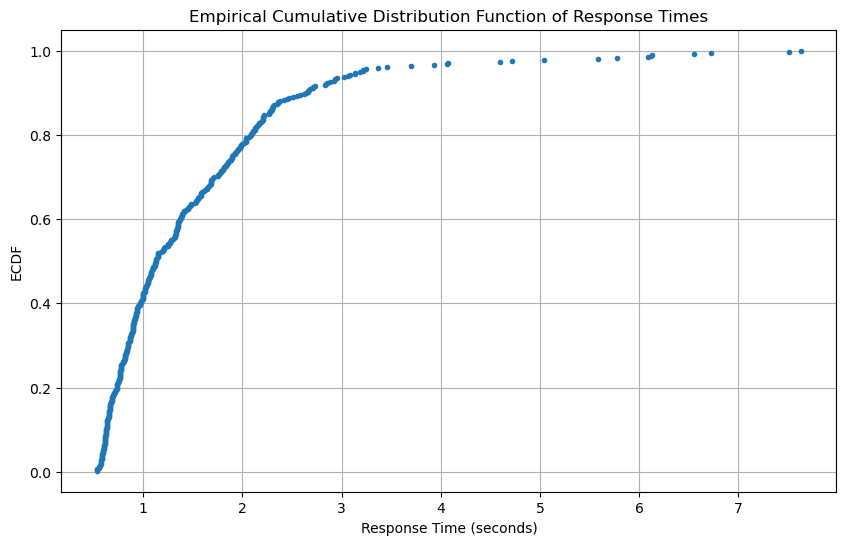

ECDF plot saved to: predict_self_gpt/response_time_ecdf.png


In [ ]:
import pandas as pd
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import re
import os


# Function 1: Generate natural language descriptions with token and time tracking
def generate_natural_language_description(df):
    """
    Convert sensor state data into a natural language description using LLM.
    Tracks token usage and response time. Adapted for event-based windows without activity column.
    """
    # 确保时间列是 datetime 类型
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # 获取窗口的起始和结束时间
    window_start = df['start_time'].min()
    window_end = df['end_time'].max()
    window_time_str = window_start.strftime('%I:%M %p').lstrip('0')
    
    # 按开始时间排序
    df = df.sort_values('start_time')
    
    # 生成事件列表
    events = []
    for _, row in df.iterrows():
        # 从 state 中提取状态名称 (e.g., Kitchen-FridgeDoorOpen)
        state_name = row['state'].split('(')[1].split(',')[0] if '(' in row['state'] else row['state']
        duration = (row['end_time'] - row['start_time']).total_seconds()
        event = {
            'state': state_name,
            'place': row['place'].lower(),
            'location': row['location'].lower(),
            'type': row['type'].lower(),
            'device': row['device'].lower(),
            'duration': int(duration) if duration > 0 else 1,
            'start_time': row['start_time'].strftime('%I:%M %p').lstrip('0'),
            'end_time': row['end_time'].strftime('%I:%M %p').lstrip('0')
        }
        events.append(event)
    
    # 构造提示词（去掉 activity 相关内容）
    prompt = f"""
    The data comes from an event-based time window starting around {window_time_str}.
    Here is the list of recorded events:
    {events}
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around {window_time_str}, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    """

    print(prompt)
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful intelligent assistant tasked with converting sensor data into smooth, natural English descriptions"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        return {
            'description': response.choices[0].message.content.strip(),
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'description': f"Error generating description: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Function 2: Classify a single description with token and time tracking
def classify_single_activity(description):
    system_prompt = """
    Act as a human activity recognition system that infers the activities performed by a subject in their home.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', and 'living room', and 'entrance (main door)'
    The system captures the subject's interactions with: Shower, Basin, Cooktop, Maindoor, Fridge, Cabinet, Cupboard, Toilet, Microwave, Seat, Bed, Toaster.
    I will provide you with a description of what happened during a specific time window, and your goal is to provide the most likely activity.
    The possible activities are: sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,snacking
    Your answer should be only one activity using the following format: ACTIVITY=(activity name)
    """
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": description}
            ],
            stream=False,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        activity_str = response.choices[0].message.content.strip()
        activity_label = extract_activity_label(activity_str)
        
        return {
            'activity': activity_label if activity_label else "Unknown",
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'activity': f"Error: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Helper function to extract activity label
def extract_activity_label(response: str) -> Optional[str]:
    """Extract the activity label from the model response."""
    match = re.search(r"ACTIVITY=(.*)", response)
    if match:
        return match.group(1).strip()
    return None

# Modified pipeline execution with tracking and ECDF plotting
def run_pipeline(windows, desc_output_path=f'predict_self_gpt_B/descriptions_{DATASET}.txt', 
                 label_output_path=f'predict_self_gpt_B/predictions_{DATASET}.txt',
                 metrics_output_path=f'predict_self_gpt_B/metrics_{DATASET}.txt'):
    """
    Run the pipeline: generate description, classify it, track metrics, and plot ECDF of response times.
    """
    os.makedirs(os.path.dirname(desc_output_path), exist_ok=True)
    
    response_times = []
    total_tokens = 0
    all_tokens = []

    with open(desc_output_path, 'w', encoding='utf-8') as desc_file, \
         open(label_output_path, 'w', encoding='utf-8') as label_file, \
         open(metrics_output_path, 'w', encoding='utf-8') as metrics_file:
        
        for idx, window in enumerate(windows):
            # Step 1: Generate description
            desc_result = generate_natural_language_description(window)
            description = desc_result['description']
            desc_time = desc_result['response_time']
            desc_tokens = desc_result['tokens_used']
            
            # Step 2: Classify the description
            class_result = classify_single_activity(description)
            activity_label = class_result['activity']
            class_time = class_result['response_time']
            class_tokens = class_result['tokens_used']
            
            # Track metrics
            response_times.extend([desc_time, class_time])
            total_tokens += desc_tokens + class_tokens
            all_tokens.extend([desc_tokens, class_tokens])

            # Print results
            print(f"Window {idx + 1}:")
            print(f"Description: {description}")
            print(f"Classified Activity: {activity_label}")
            print(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}")
            print(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n")
            
            # Save to files
            desc_file.write(f"{description}\n")
            label_file.write(f"{activity_label}\n")
            metrics_file.write(f"Window {idx + 1}:\n")
            metrics_file.write(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}\n")
            metrics_file.write(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n\n")

        print(f"\nTotal windows processed: {len(windows)}")
        print(f"Total tokens used: {total_tokens}")
        print(f"Descriptions saved to: {desc_output_path}")
        print(f"Activity labels saved to: {label_output_path}")
        print(f"Metrics saved to: {metrics_output_path}") # 添加了metrics的保存路径输出

        # Save all tokens to the metrics file
        # metrics_file.write("\nAll tokens used (description, classification):\n")
        # for tokens in all_tokens:
        #     metrics_file.write(f"{tokens}\n")

    # Generate and plot ECDF
    plot_ecdf(response_times)

def plot_ecdf(response_times):
    """Generate and display ECDF plot of response times."""
    sorted_times = np.sort(response_times)
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y, marker='.', linestyle='none')
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function of Response Times')
    plt.grid(True)
    
    # Save plot
    plot_path = f'predict_self_gpt_B/response_time_ecdf.png'
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.show()
    print(f"ECDF plot saved to: {plot_path}")

# Run the pipeline
test = loaded_dataframes.copy()
run_pipeline(test)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file='predict_self_gpt_B/evaluation.txt'):
    """
    评估预测标签，预测标签中只要有一个属于真实标签就算对，未预测到不算错。
    输出每个类别的 F1 分数和混淆矩阵图像。
    """
    try:
        with open(true_labels_file, 'r') as f:
            true_labels_raw = [line.strip() for line in f]

        with open(predicted_labels_file, 'r') as f:
            predicted_labels_raw = [line.strip() for line in f]

        if len(true_labels_raw) != len(predicted_labels_raw):
            raise ValueError("真实标签的数量与预测标签的数量不匹配。")

        # 拆分标签
        true_labels_split = [label.split(',') for label in true_labels_raw]
        predicted_labels_split = [label.split(',') for label in predicted_labels_raw]

        true_labels_split = [[label.strip() for label in sublist] for sublist in true_labels_split]
        predicted_labels_split = [[label.strip() for label in sublist] for sublist in predicted_labels_split]

        # 获取所有唯一标签
        all_labels = set()
        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            all_labels.update(true_labels)
            all_labels.update(predicted_labels)
        unique_labels = sorted(list(all_labels))

        # 初始化评估列表（每个窗口一个结果）
        y_true = []
        y_pred = []

        # 逐窗口评估：预测标签中有一个在真实标签中就算对
        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            # 检查是否有匹配
            match = any(pred_label in true_labels for pred_label in predicted_labels)
            # 如果有匹配，选择第一个匹配的真实标签作为正类，否则取第一个真实标签
            if match:
                # 找到第一个匹配的标签
                matched_label = next(pred_label for pred_label in predicted_labels if pred_label in true_labels)
                y_true.append(true_labels[0])  # 真实标签取第一个（代表窗口）
                y_pred.append(matched_label)   # 预测标签取匹配的那个
            else:
                # 无匹配时，预测标签为空或无关标签，取真实标签的第一个作为基准
                y_true.append(true_labels[0])
                y_pred.append(true_labels[0] if not predicted_labels else predicted_labels[0])

        # 将标签转换为索引
        label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        y_true_idx = [label_to_idx[label] for label in y_true]
        y_pred_idx = [label_to_idx[label] for label in y_pred]

        # 计算混淆矩阵
        cm = confusion_matrix(y_true_idx, y_pred_idx)
        cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)  # 归一化混淆矩阵

        # 写入评估结果
        with open(output_file, 'w') as output:
            output.write("Classification Report:\n")
            output.write(classification_report(y_true_idx, y_pred_idx, target_names=unique_labels))

            output.write("\nConfusion Matrix:\n")
            output.write(np.array2string(cm))

            f1_macro = f1_score(y_true_idx, y_pred_idx, average='macro')
            output.write(f"\nF1 Macro Score: {f1_macro}\n")

            f1_per_class = f1_score(y_true_idx, y_pred_idx, average=None)
            output.write("\nF1 Score per Class:\n")
            for i, label in enumerate(unique_labels):
                output.write(f"  {label}: {f1_per_class[i]}\n")

        # 绘制混淆矩阵图像
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Normalized Confusion Matrix')
        plt.tight_layout()

        # 保存混淆矩阵图像
        plot_path = f'predict_self_gpt_B/confusion_matrix.png'
        os.makedirs(os.path.dirname(plot_path), exist_ok=True)
        plt.savefig(plot_path)
        plt.close()

        print(f"评估结果已保存到 {output_file} 和 {plot_path}")

    except FileNotFoundError:
        print("Error: 文件未找到。")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 示例用法
true_labels_file = f'predict_self_gpt_B/truth_labels_{DATASET}.txt'
predicted_labels_file = f'predict_self_gpt_B/predictions_{DATASET}.txt'
output_file = f'predict_self_gpt_B/evaluation_{DATASET}.txt'

evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file)

评估结果已保存到 predict_self_gpt/evaluation_A.txt 和 predict_self_gpt/confusion_matrix.png
